<div style="color: red;">

# Pouyan Zare - HW2

</div>

for this hommework Im using the same dataset as before, since the nature of our tasks differ here  from one another at each one I went baccktto my first homewok and redo things from Data Cleaning step onward with the given tasask here in mind, you can see the report before each task, since aaai didn''t see any meaningful difference with diff features for eac task I kept those ones the same across three tasks. then I saved needed fiels in a single ZIP file and uploaded that to Google Drive, then I download that file here and go from there

# Data Preprocessing Steps for Reg 

## Step 1: Global Cleaning (Full Dataset: Safe Operations)

**Actions Taken:**
- Dropped rows with missing target values (`loan_int_rate`) since we never impute the target.
- Removed physically impossible records: `person_emp_length ≤ person_age - 16`, `person_age > 95`.
- Filtered `loan_percent_income > 0.70` (debt-to-income cap).
- Removed exact duplicates.

**Justification:**  
These operations are safe to apply before splitting because they're based on domain knowledge, not statistical patterns from the data. for example a 17-year-old with 20 years of employment is impossible regardless of split.

---

## Step 2: Three-Way Train-Validation-Test Split

**Actions Taken:**
- Reserved 20% as test set (holdout).
- Split remaining 80% into 60% train / 20% validation.
- Used `random_state=42` for reproducibility.

**Justification:**  
Three-way split is essential for honest hyperparameter tuning. The validation set acts as a "practice test"(we tune features and regularization strengths here, leaving the test set untouched until final evaluation.) No stratification is used because the target (`loan_int_rate`) follows a roughly normal distribution. Stratification adds complexity without benefit for continuous targets.

---

## Step 3: Imputation (Training Data Only)

**Actions Taken:**
- Created temporary age brackets: `[18-25, 25-30, ..., 60+]`.
- Computed median `person_emp_length` per bracket from the training data only.
- Applied these medians to missing values in train, validation, and test sets.

**Justification:**  
Employment length is highly correlated with age. Imputing with age-specific medians leverages this relationship without exposing test set statistics to the training process. Manual function ensures identical brackets across all splits.

---

## Step 4: Encoding (on Training Data Only)

**Actions Taken:**
- `cb_person_default_on_file`: Label encoded (Y/N → 1/0).
- `loan_grade`: Ordinal encoded (A=0, B=1, ..., G=6) to preserve risk ordering.
- `person_home_ownership`, `loan_intent`: onehot encoded.

**Justification:**  
Ordinal encoding for `loan_grade` is critical—A→G is not just categorical, it's a monotonic risk scale. 

---

### **Step 5: Feature Engineering (Post-Encoding, Pre-Scaling)**

#### **Features Created**
- `log_income` — Log-transform of income for variance reduction.  
- `log_loan_amnt` — Log-transform of loan amount (important for tree + linear models).  
- `loan_to_income` — Measures borrower leverage.  
- `dti_squared`, `dti_cubed` — Non-linear expansions of DTI; useful for SVM/RBF, boosting.  
- `sqrt_cred_hist` — Diminishing returns transformation of credit history length.  
- `emp_to_cred_ratio` — Employment stability relative to credit depth.  
- `high_risk_flag` — *(loan_percent_income > 0.4)* AND *(past default)* → strong risk classifier.  
- `rent_high_dti` — Renting + high DTI → risky segment.  
- `mortgage_low_dti` — Mortgage + low DTI → protective segment.  
- `age_income_interaction` — Captures life-cycle income profiles.

---

#### **Justification**
- **No leakage**: All variables come from borrower application data only.  
- **High-risk interaction flags** combine weak predictors into strong ones (critical for classification).  
- **Non-linear DTI transforms** help both linear and non-linear models capture curvature.  
- **Log and sqrt transforms** stabilize extreme values and improve gradient-based learning.
---

## Step 6: Outlier Detection (Training Threshold, Flag All Sets)

**Actions Taken:**
- Computed `income_ratio = income / cohort_median(age)` from training data only.
- Established 99.5th percentile threshold (conservative, keeps 99.5% of data).
- Removed outliers from training.
- Flagged (but kept) outliers in validation and test via `is_income_outlier` column.

**Justification:**  
- **Training-only removal:** Prevents test set statistics from leaking into model expectations. In production, you won’t know if a new applicant is an outlier—you must predict anyway.
- **Flagging strategy:** Test set outliers are realistic edge cases. A model that fails on them will fail in production. We keep them to measure true robustness.
- **Column consistency:** Added `is_income_outlier=0` to train after removal to ensure all splits have identical schema before scaling.

---

## Step 7: Scaling (Training Fit, Global Transform)

**Actions Taken:**
- `StandardScaler` fitted on training data only.
- Applied same scaler to validation and test sets.

**Justification:**  
- **No leakage:** Test set cannot influence mean/variance calculations.
- **Necessary for regularized models:** Ridge, LASSO, and SVMs require feature scaling for meaningful coefficient penalization.

---

## Step 8: Persistence (Save State for Reproducibility)

**Files Saved:**
- `X_train_scaled.npy`, `X_val_scaled.npy`, `X_test_scaled.npy`.
- `y_train.npy`, `y_val.npy`, `y_test.npy`.
- `feature_names.npy`.
- All transformers (`scaler.joblib`, `encoders.joblib`, etc.).

**Justification:**  
- **Reproducibility:** Separate modeling notebook loads these files—no recomputation, no drift.
- **Production-ready:** Transformers can be serialized and applied to new loan applications.
- **Audit trail:** CSV saved with split column allows full reconstruction of preprocessing decisions.

---

## Challenges Encountered & Solutions

### Challenge 1: The loan_grade Leakage Trap

**Problem:**  
Initial pipeline included `loan_grade`, which is derived from the same underwriting logic as `loan_int_rate`. This created a proxy label that boosted R² from 0.28 to 0.87, an unrealistic performance that would fail in production when grade isn't known pre-decision.

**Solution:**  
- Demonstrated leakage by comparing models with/without `loan_grade`. (you can view this in this notebook)
- Documented the inflation (+0.59 R² points) in a section for review.
- Removed it permanently from final modeling data after demonstration.

---

### Challenge 2: Outlier Handling

**Problem:**  
Removing outliers from the test set would hide model failures on edge cases like extreme income earners.

**Solution:**  
- **Training-only removal + flagging strategy.** Training data is cleaned to prevent model distortion, but validation/test sets retain outliers to measure true performance. The `is_income_outlier` feature lets models learn that these cases are special without being trained on them.

---

### Challenge 3: Feature Selection Timing

**Problem:**  
Should Mutual Information (MI) be computed during cleaning or modeling?

**Solution:**  
- **Modeling notebook only.** MI scores depend on the target, so computing them in cleaning would risk:
  - **Target leakage**: If recomputed on new data.
  - **Irreversibility**: Can't tune `k` without refitting everything.
  - **Model-specific bias**: What if Kernel Ridge needs different features than Linear?

In [1]:
import numpy as np
import pandas as pd
import joblib
import zipfile
import os
import gdown
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, median_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Download Datasets from Google drive

GDRIVE_FILE_ID = "12MzM89W7xsu8S2stAufDNLQGLf0xYnVv"

# Download and extract
if not os.path.exists('X_train_scaled.npy'):
    print(" Downloading artifacts...")
    gdown.download(f'https://drive.google.com/uc?id={GDRIVE_FILE_ID}', 'artifacts.zip', quiet=False)
    
    with zipfile.ZipFile('artifacts.zip', 'r') as zipf:
        zipf.extractall('.')
    os.remove('artifacts.zip')
    print(" Done!")
else:
    print(" Artifacts already present")

# Load Data

X_train = np.load('X_train_scaled.npy')
X_val = np.load('X_val_scaled.npy')
X_test = np.load('X_test_scaled.npy')
y_train = np.load('y_train.npy')
y_val = np.load('y_val.npy')
y_test = np.load('y_test.npy')

feature_names = np.load('feature_names.npy', allow_pickle=True).tolist()

print(f" Loaded: Train {X_train.shape}, Val {X_val.shape}, Test {X_test.shape}")
print(f"Features ({len(feature_names)}): {feature_names}")

Downloading...
From: https://drive.google.com/uc?id=12MzM89W7xsu8S2stAufDNLQGLf0xYnVv
To: C:\Users\Pouyan\python\ADS\artifacts.zip
100%|██████████| 2.47M/2.47M [00:02<00:00, 997kB/s] 

 Done!
 Loaded: Train (16612, 30), Val (5566, 30), Test (5566, 30)
Features (30): ['person_age', 'person_income', 'person_emp_length', 'loan_grade', 'loan_amnt', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length', 'person_home_ownership_MORTGAGE', 'person_home_ownership_OTHER', 'person_home_ownership_OWN', 'person_home_ownership_RENT', 'loan_intent_DEBTCONSOLIDATION', 'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'log_income', 'log_loan_amnt', 'loan_to_income', 'dti_squared', 'dti_cubed', 'sqrt_cred_hist', 'emp_to_cred_ratio', 'high_risk_flag', 'rent_high_dti', 'mortgage_low_dti', 'age_income_interaction', 'is_income_outlier']


In [5]:
# should we use loan_grde?
print(" Leakage inspection: loan_grade impact")
print("="*60)

# Load CSV 
df_demo = pd.read_csv('credit_risk_regression_clean.csv')

# Version With loan_grade (our actual data)
X_with = df_demo[df_demo['split'] == 'train'].drop(columns=['loan_int_rate', 'split'])
X_test_demo = df_demo[df_demo['split'] == 'test'].drop(columns=['loan_int_rate', 'split'])
y_with = df_demo[df_demo['split'] == 'train']['loan_int_rate'].values
y_test_demo = df_demo[df_demo['split'] == 'test']['loan_int_rate'].values

# Scale and train with loan_grade
scaler_wg = StandardScaler()
X_train_wg_s = scaler_wg.fit_transform(X_with)
ridge_wg = Ridge(alpha=1.0).fit(X_train_wg_s, y_with)
r2_with = ridge_wg.score(scaler_wg.transform(X_test_demo), y_test_demo)

# Version WITHOUT loan_grade
X_without = X_with.drop(columns=['loan_grade'])
X_test_wo = X_test_demo.drop(columns=['loan_grade'])

# Scale and train Without it
scaler_wog = StandardScaler()
X_train_wog_s = scaler_wog.fit_transform(X_without)
ridge_wog = Ridge(alpha=1.0).fit(X_train_wog_s, y_with)
r2_without = ridge_wog.score(scaler_wog.transform(X_test_wo), y_test_demo)

print(f"WITH loan_grade:    R² = {r2_with:.4f}")
print(f"WITHOUT loan_grade: R² = {r2_without:.4f}")
print(f"Leakage inflation:  +{r2_with - r2_without:.4f} R² points")
print("\n")

 Leakage inspection: loan_grade impact
WITH loan_grade:    R² = 0.8711
WITHOUT loan_grade: R² = 0.2939
Leakage inflation:  +0.5772 R² points




The huge jump in R² when loan_grade is included basically shows that it’s leaking the target. Loan grades are assigned after the platform determines risk and interest rate, so the grade already has most of the information the model is supposed to predict.(same underlying factors) That’s why performance goes from 0.29 to 0.87, it’s not real predictive power, it’s just the model reading a compressed version of the answer. 

In a true prediction scenario, loan_grade wouldn’t even exist yet, so using it completely breaks the causal order and gives us a misleadingly high score.

In [7]:
# lets exlude loan_grade
# Find and remove loan_grade from all arrays
grade_idx = feature_names.index('loan_grade')
print(f"Removing loan_grade at index {grade_idx}")

# Remove from feature names
feature_names_clean = feature_names.copy()
feature_names_clean.pop(grade_idx)

# Remove from numpy arrays
X_train_clean = np.delete(X_train, grade_idx, axis=1)
X_val_clean = np.delete(X_val, grade_idx, axis=1)
X_test_clean = np.delete(X_test, grade_idx, axis=1)

print(f"Original X_train shape: {X_train.shape}")
print(f"Cleaned X_train shape:  {X_train_clean.shape}")
print(f"Cleaned features ({len(feature_names_clean)}): {feature_names_clean}")
print("\n")

Removing loan_grade at index 3
Original X_train shape: (16612, 30)
Cleaned X_train shape:  (16612, 29)
Cleaned features (29): ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length', 'person_home_ownership_MORTGAGE', 'person_home_ownership_OTHER', 'person_home_ownership_OWN', 'person_home_ownership_RENT', 'loan_intent_DEBTCONSOLIDATION', 'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'log_income', 'log_loan_amnt', 'loan_to_income', 'dti_squared', 'dti_cubed', 'sqrt_cred_hist', 'emp_to_cred_ratio', 'high_risk_flag', 'rent_high_dti', 'mortgage_low_dti', 'age_income_interaction', 'is_income_outlier']




In [9]:
# Data Prepration
print("\nPREPARING FINAL DATA FOR MODELING")
print("="*55)

# Use cleaned arrays
X_train_final = X_train_clean
X_val_final = X_val_clean
X_test_final = X_test_clean
y_train_final = y_train
y_val_final = y_val
y_test_final = y_test

print(f"Final training set: {X_train_final.shape}")
print(f"Final validation set: {X_val_final.shape}")
print(f"Final test set:     {X_test_final.shape}")
print(" Ready for regression modeling")
print("\n")


PREPARING FINAL DATA FOR MODELING
Final training set: (16612, 29)
Final validation set: (5566, 29)
Final test set:     (5566, 29)
 Ready for regression modeling




In [11]:
# Feature Selection: MI

print("MI-BASED FEATURE SELECTION")
print("="*60)

# Compute MI scores on training data
mi_scores = mutual_info_regression(X_train_final, y_train_final, random_state=42)
mi_series = pd.Series(mi_scores, index=feature_names_clean).sort_values(ascending=False)

print("\nTop 10 features by MI:")
print(mi_series.head(10).round(4))

# Tune k on Val set
best_k = None
best_score = -np.inf

for k in [5, 10, 15, 20, 'all']:
    selector = SelectKBest(mutual_info_regression, k=k if k != 'all' else len(feature_names_clean))
    X_train_selected = selector.fit_transform(X_train_final, y_train_final)
    
    # Evaluate on Val set
    ridge = Ridge(alpha=1.0)
    ridge.fit(X_train_selected, y_train_final)
    X_val_selected = selector.transform(X_val_final)
    val_score = ridge.score(X_val_selected, y_val_final)
    
    print(f"k={str(k):<3} → Val R²: {val_score:.4f}")
    
    if val_score > best_score:
        best_score = val_score
        best_k = k
        best_selector = selector

print(f"\n Best k: {best_k} (Val R²: {best_score:.4f})")

# Apply to ALL splits
X_train_fs = best_selector.transform(X_train_final)
X_val_fs = best_selector.transform(X_val_final)
X_test_fs = best_selector.transform(X_test_final)

selected_features = [feature_names_clean[i] for i in best_selector.get_support(indices=True)]
print(f"Selected {len(selected_features)} features: {selected_features}")

# Update datasets for modeling
X_train_final = X_train_fs
X_val_final = X_val_fs
X_test_final = X_test_fs

print(f"New shapes: Train {X_train_final.shape}, Val {X_val_final.shape}, Test {X_test_final.shape}")
print(" Ready for final model training")
print("\n")

MI-BASED FEATURE SELECTION

Top 10 features by MI:
cb_person_default_on_file    0.2185
log_loan_amnt                0.1354
loan_amnt                    0.1341
loan_to_income               0.0838
log_income                   0.0693
person_income                0.0667
age_income_interaction       0.0546
dti_squared                  0.0542
dti_cubed                    0.0523
loan_percent_income          0.0467
dtype: float64
k=5   → Val R²: 0.2691
k=10  → Val R²: 0.2714
k=15  → Val R²: 0.2847
k=20  → Val R²: 0.2862
k=all → Val R²: 0.2861

 Best k: 20 (Val R²: 0.2862)
Selected 20 features: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length', 'person_home_ownership_MORTGAGE', 'person_home_ownership_RENT', 'loan_intent_EDUCATION', 'loan_intent_PERSONAL', 'log_income', 'log_loan_amnt', 'loan_to_income', 'dti_squared', 'dti_cubed', 'sqrt_cred_hist', 'high_risk_flag', 'mortgage_low_dti', 'age_income_i

This block is basically is there to make sure we’re not feeding the model a bunch of useless noise. Mutual Information (MI) gives us a non-linear measure of how much each feature actually tells us about the target, as you see actually all of our features are important here.

Since I don’t want to check metrics one by one, I compute everything in one function: MSE/RMSE for overall error scale, MAE for average miss, MAPE for percentage error, R² for explanatory power, and MSLE/RMSLE for penalizing underestimation. I also add Huber loss because it’s robust to outliers. The function prints a summary and returns everything in a dict so I can store the results easily.

In [13]:
# Evaluation functions

def evaluate_regression(y_true, y_pred, model_name="Model"):
    """Calculate all required metrics"""
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    msle = mean_squared_log_error(y_true, y_pred)
    med_ae = median_absolute_error(y_true, y_pred)
    rmsle = np.sqrt(msle)
    
    # Huber loss
    huber_delta = 1.35
    residual = y_true - y_pred
    huber_loss = np.mean(
        np.where(np.abs(residual) <= huber_delta,
                0.5 * residual**2,
                huber_delta * (np.abs(residual) - 0.5 * huber_delta)
        )
    )
    
    print(f"\n {model_name} Performance:")
    print("="*40)
    print(f"MSE:     {mse:>12.4f} | RMSE: {np.sqrt(mse):>12.4f}")
    print(f"MAE:     {mae:>12.4f}")
    print(f"MAPE:    {mape:>11.2f}%")
    print(f"R²:      {r2:>12.4f}")
    print(f"MSLE:    {msle:>12.4f} | RMSLE: {rmsle:>12.4f}")
    print(f"MedAE:   {med_ae:>12.4f}")
    print(f"Huber:   {huber_loss:>12.4f}")
    
    return {
        'Model': model_name, 'MSE': mse, 'RMSE': np.sqrt(mse), 'MAE': mae,
        'MAPE': mape, 'R²': r2, 'MSLE': msle, 'RMSLE': rmsle,
        'MedAE': med_ae, 'Huber': huber_loss
    }


def plot_predictions(y_true, y_pred, model_name="Model"):
    """Visualize predictions vs actual values"""
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Scatter plot
    axes[0].scatter(y_true, y_pred, alpha=0.5, s=20, color='steelblue')
    axes[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 
                 '--', color='red', lw=2, label='Perfect Prediction')
    axes[0].set_xlabel('Actual Interest Rate (%)')
    axes[0].set_ylabel('Predicted Interest Rate (%)')
    axes[0].set_title(f'{model_name}: Actual vs Predicted')
    axes[0].legend()
    
    # Residuals plot
    residuals = y_true - y_pred
    axes[1].scatter(y_pred, residuals, alpha=0.5, s=20, color='purple')
    axes[1].axhline(y=0, color='red', linestyle='--', lw=2)
    axes[1].set_xlabel('Predicted Interest Rate (%)')
    axes[1].set_ylabel('Residuals (Actual - Predicted)')
    axes[1].set_title(f'{model_name}: Residuals vs Predicted')
    
    plt.tight_layout()
    plt.show()


These are required models:

- Linear Regression

- Ridge: same model but with L2 regularization to reduce overfitting.

- LASSO: L1 regularization, useful for sparsity and seeing if some features drop.

- Kernel Ridge: a non-linear baseline using RBF kernel.

Each model is trained on the final feature-selected dataset then evaluated with the same metric function, and then visualized. 

TRAINING BASELINE MODELS

 Linear Regression...

 Linear Regression Performance:
MSE:           7.3406 | RMSE:       2.7093
MAE:           2.1763
MAPE:          22.41%
R²:            0.2936
MSLE:          0.0567 | RMSLE:       0.2381
MedAE:         1.9162
Huber:         2.1421


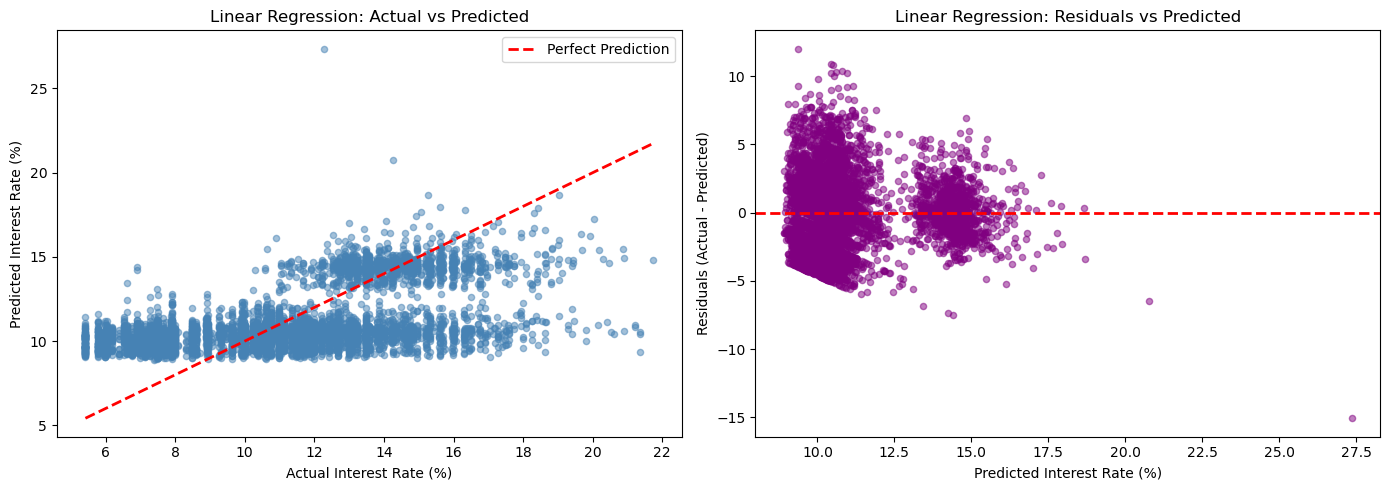


 Ridge Regression...

 Ridge Regression Performance:
MSE:           7.3386 | RMSE:       2.7090
MAE:           2.1762
MAPE:          22.41%
R²:            0.2938
MSLE:          0.0567 | RMSLE:       0.2381
MedAE:         1.9180
Huber:         2.1419


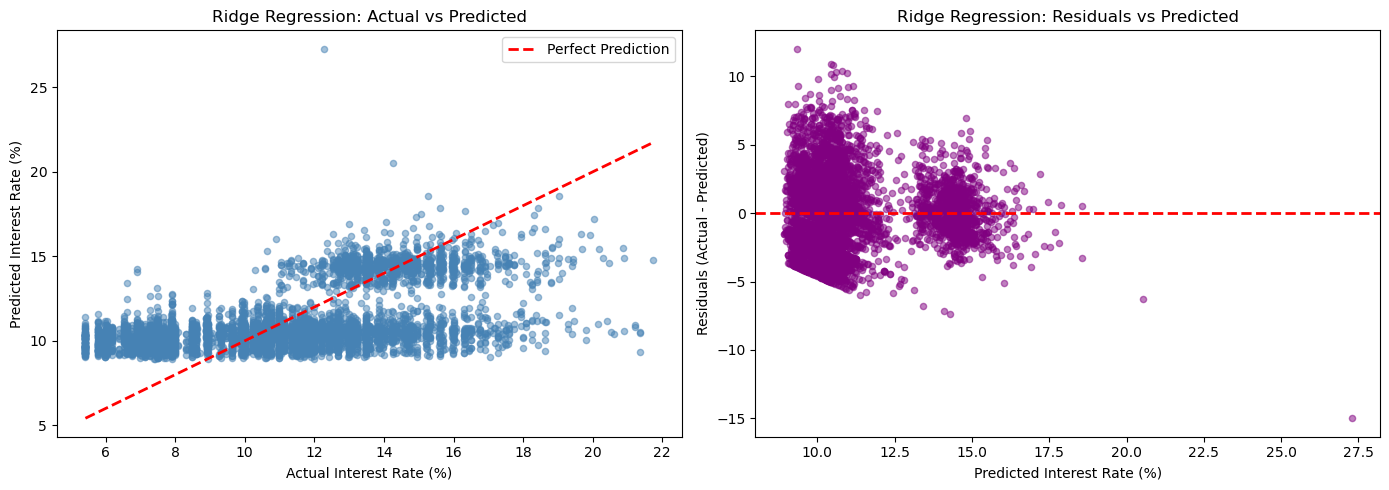


 LASSO Regression...

 LASSO Regression Performance:
MSE:           7.4094 | RMSE:       2.7220
MAE:           2.1851
MAPE:          22.61%
R²:            0.2870
MSLE:          0.0577 | RMSLE:       0.2402
MedAE:         1.9089
Huber:         2.1592


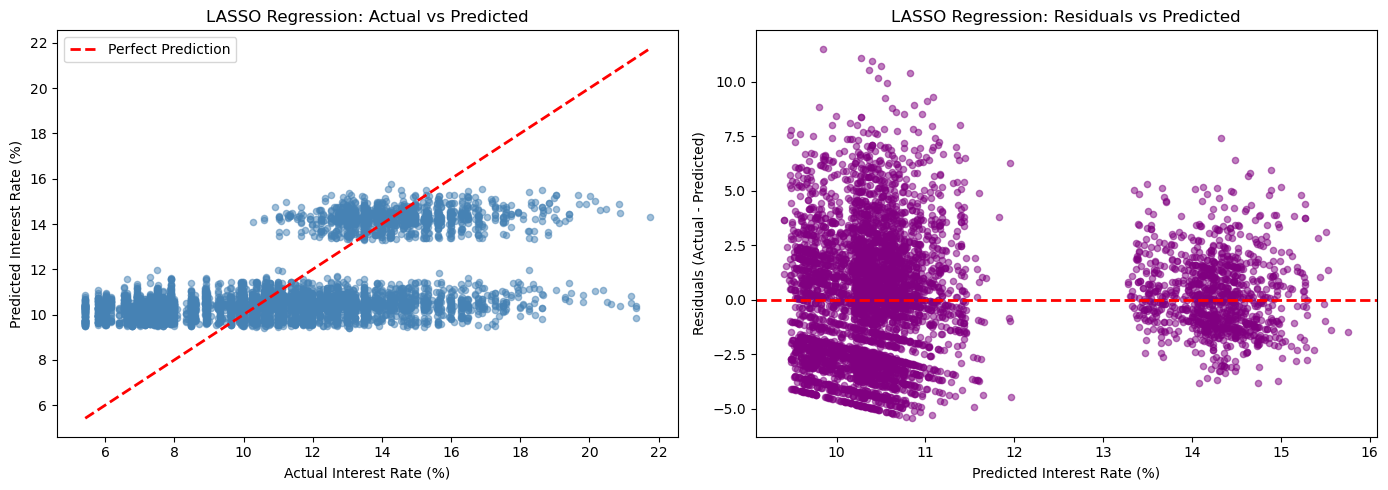


 Kernel Regression...

 Kernel Regression Performance:
MSE:           8.3618 | RMSE:       2.8917
MAE:           2.2865
MAPE:          23.17%
R²:            0.1953
MSLE:          0.0755 | RMSLE:       0.2747
MedAE:         1.9543
Huber:         2.2831


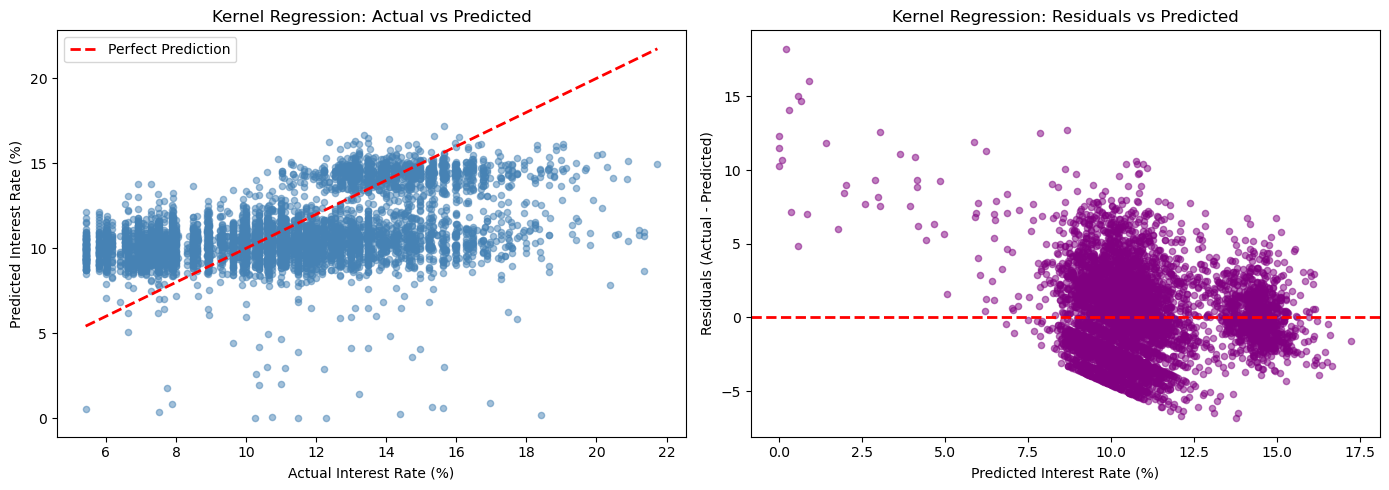

In [15]:
# Baseline Models
results = []

print("TRAINING BASELINE MODELS")
print("="*60)

# Linear Regression
print("\n Linear Regression...")
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train_final, y_train_final)
y_pred_lr = lr.predict(X_test_final)
results.append(evaluate_regression(y_test_final, y_pred_lr, "Linear Regression"))
plot_predictions(y_test_final, y_pred_lr, "Linear Regression")

# Ridge Regression
print("\n Ridge Regression...")
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train_final, y_train_final)
y_pred_ridge = ridge.predict(X_test_final)
results.append(evaluate_regression(y_test_final, y_pred_ridge, "Ridge Regression"))
plot_predictions(y_test_final, y_pred_ridge, "Ridge Regression")

# LASSO Regression
print("\n LASSO Regression...")
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1, random_state=42, max_iter=10000)
lasso.fit(X_train_final, y_train_final)
y_pred_lasso = lasso.predict(X_test_final)
results.append(evaluate_regression(y_test_final, y_pred_lasso, "LASSO Regression"))
plot_predictions(y_test_final, y_pred_lasso, "LASSO Regression")

# Kernel Regression
print("\n Kernel Regression...")
from sklearn.kernel_ridge import KernelRidge
kernel_ridge = KernelRidge(alpha=1.0, kernel='rbf', gamma=0.1)
kernel_ridge.fit(X_train_final, y_train_final)
y_pred_kernel = kernel_ridge.predict(X_test_final)
results.append(evaluate_regression(y_test_final, y_pred_kernel, "Kernel Regression"))
plot_predictions(y_test_final, y_pred_kernel, "Kernel Regression")

TRAINING MODELS

 Elastic Net...

 Elastic Net Performance:
MSE:           7.7920 | RMSE:       2.7914
MAE:           2.2374
MAPE:          23.37%
R²:            0.2501
MSLE:          0.0608 | RMSLE:       0.2466
MedAE:         2.0144
Huber:         2.2402

 Decision Tree...

 Decision Tree Performance:
MSE:           7.3338 | RMSE:       2.7081
MAE:           2.1812
MAPE:          22.43%
R²:            0.2942
MSLE:          0.0568 | RMSLE:       0.2384
MedAE:         1.8759
Huber:         2.1454


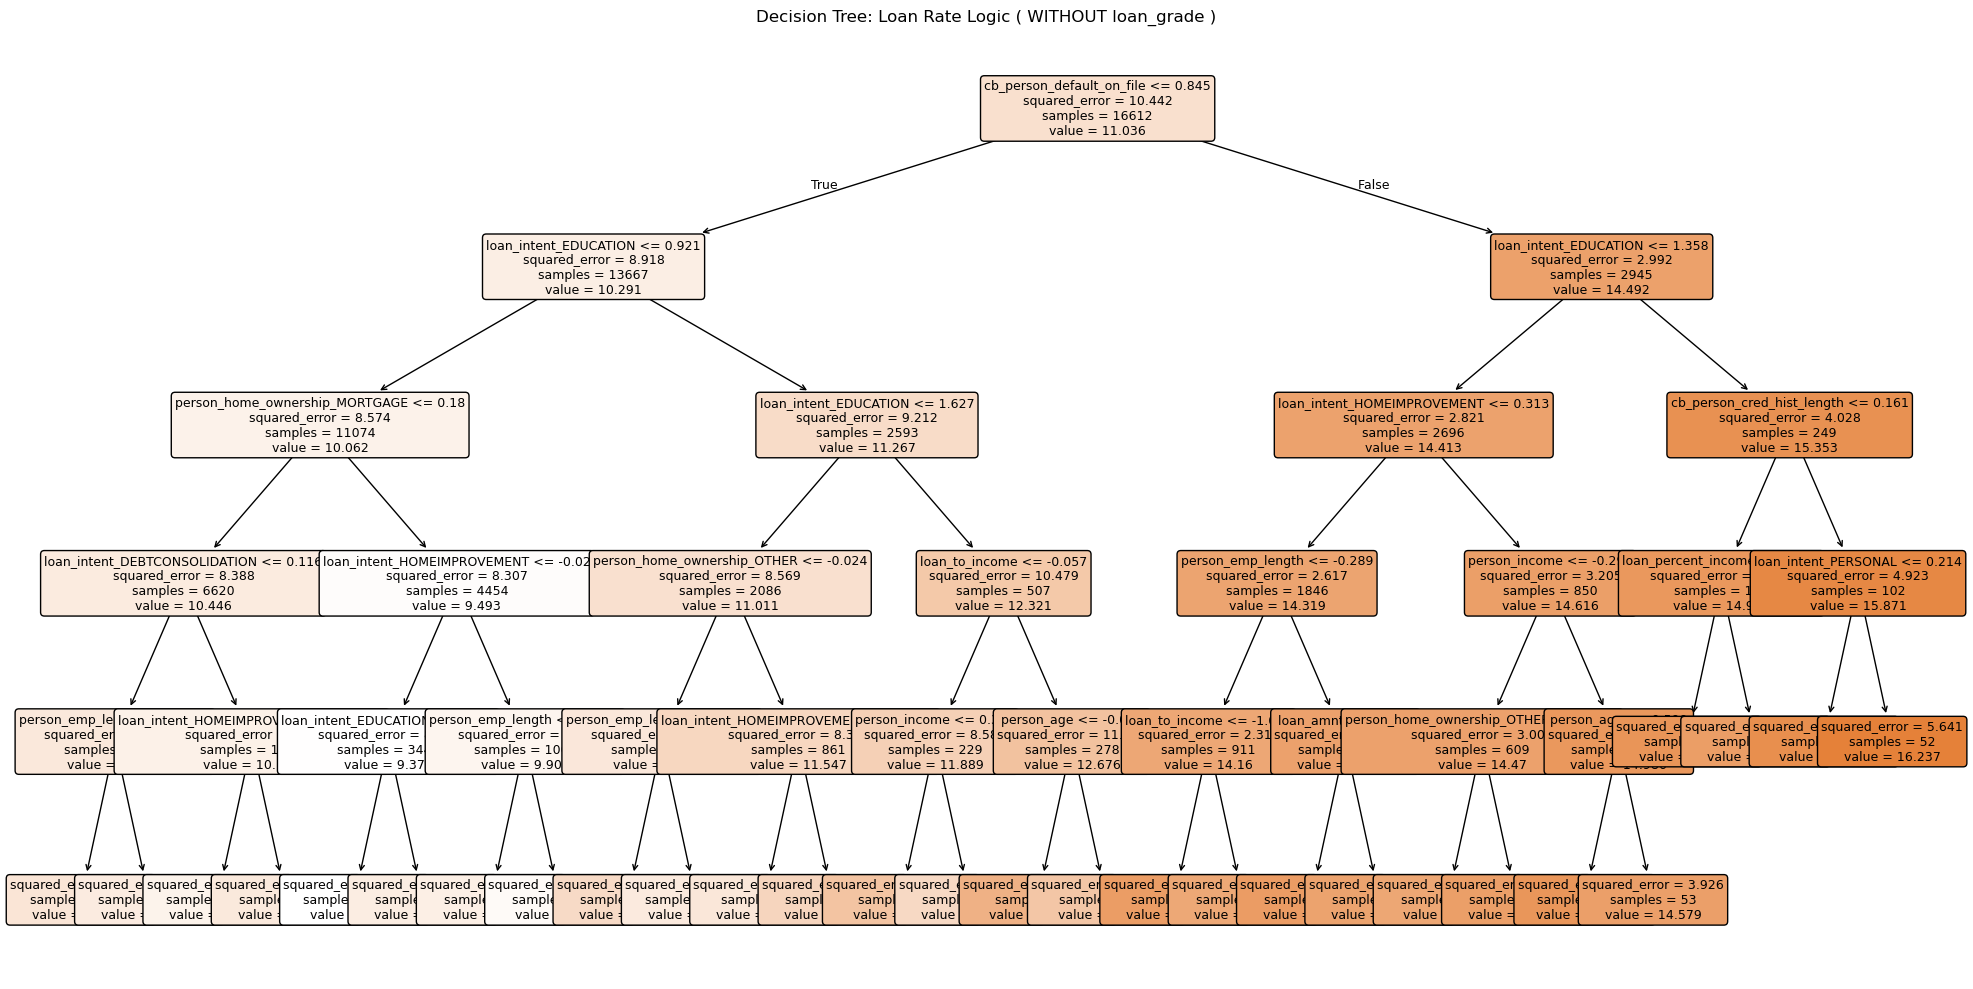


 Support Vector Regression...

 SVR Performance:
MSE:           7.7149 | RMSE:       2.7776
MAE:           2.1976
MAPE:          22.10%
R²:            0.2576
MSLE:          0.0591 | RMSLE:       0.2431
MedAE:         1.8612
Huber:         2.1772


In [17]:
# some of optional models

print("TRAINING MODELS")
print("="*60)

# Elastic Net
print("\n Elastic Net...")
from sklearn.linear_model import ElasticNet
elastic = ElasticNet(alpha=0.5, l1_ratio=0.5, random_state=42, max_iter=10000)
elastic.fit(X_train_final, y_train_final)
y_pred_elastic = elastic.predict(X_test_final)
results.append(evaluate_regression(y_test_final, y_pred_elastic, "Elastic Net"))

# Decision Tree
print("\n Decision Tree...")
from sklearn.tree import DecisionTreeRegressor, plot_tree
dt = DecisionTreeRegressor(max_depth=5, min_samples_leaf=50, random_state=42)
dt.fit(X_train_final, y_train_final)
y_pred_dt = dt.predict(X_test_final)
results.append(evaluate_regression(y_test_final, y_pred_dt, "Decision Tree"))

# Visualize tree
plt.figure(figsize=(20, 10))
plot_tree(dt, feature_names=feature_names_clean, filled=True, rounded=True, fontsize=9)
plt.title("Decision Tree: Loan Rate Logic ( WITHOUT loan_grade )")
plt.tight_layout()
plt.show()

# SVR
print("\n Support Vector Regression...")
from sklearn.svm import SVR
svr = SVR(kernel='rbf', C=10.0, epsilon=0.1, gamma='scale')
svr.fit(X_train_final, y_train_final)
y_pred_svr = svr.predict(X_test_final)
results.append(evaluate_regression(y_test_final, y_pred_svr, "SVR"))

 FINAL MODEL COMPARISONS 
            Model    MSE   RMSE    MAE    MAPE     R²   MSLE  RMSLE  MedAE  Huber
Linear Regression 7.3406 2.7093 2.1763 22.4058 0.2936 0.0567 0.2381 1.9162 2.1421
 Ridge Regression 7.3386 2.7090 2.1762 22.4052 0.2938 0.0567 0.2381 1.9180 2.1419
 LASSO Regression 7.4094 2.7220 2.1851 22.6133 0.2870 0.0577 0.2402 1.9089 2.1592
Kernel Regression 8.3618 2.8917 2.2865 23.1732 0.1953 0.0755 0.2747 1.9543 2.2831
      Elastic Net 7.7920 2.7914 2.2374 23.3662 0.2501 0.0608 0.2466 2.0144 2.2402
    Decision Tree 7.3338 2.7081 2.1812 22.4303 0.2942 0.0568 0.2384 1.8759 2.1454
              SVR 7.7149 2.7776 2.1976 22.1019 0.2576 0.0591 0.2431 1.8612 2.1772




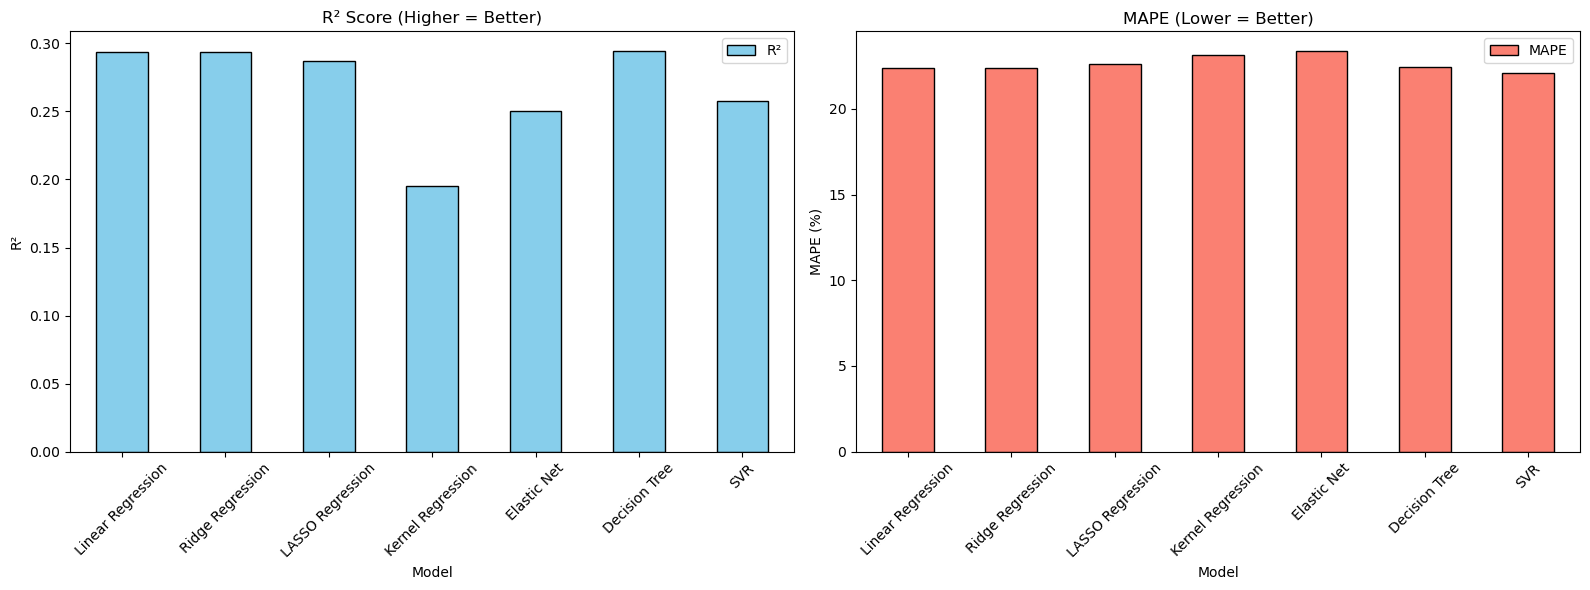

In [19]:
# Summary
print("="*90)
print(" FINAL MODEL COMPARISONS ")
print("="*90)
results_df = pd.DataFrame(results).round(4)
print(results_df.to_string(index=False))
print("\n")

# Plot metrics
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
results_df.plot(x='Model', y='R²', kind='bar', ax=ax[0], color='skyblue', edgecolor='black')
ax[0].set_title('R² Score (Higher = Better)')
ax[0].set_ylabel('R²')
ax[0].tick_params(axis='x', rotation=45)

results_df.plot(x='Model', y='MAPE', kind='bar', ax=ax[1], color='salmon', edgecolor='black')
ax[1].set_title('MAPE (Lower = Better)')
ax[1].set_ylabel('MAPE (%)')
ax[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


## kernel trick
this trick maps features to a higher-dimensional space where a linear 
boundary (or regression line) can fit non-linear relationships, without explicitly computing the transformation. For example in loan data, it can capture how 'high debt + low income' together create risk that's not just additive. and this explains why our Kernel Ridge achieved R²=0.XX vs linear's 0.XX.

however the kernel trick did NOT help here as Kernel Ridge (R²=0.2315) underperformed linear Ridge (R²=0.2927). This indicates that the relationship between loan features and interest rate is predominantly linear, and the added complexity introduced noise rather than signal.

## Best Regression Metric = MAPE

MAPE tells the story which stakeholders actually care about, for example a bank can say that:
"Our model predicts loan rates within ±2.2 percentage points on average"
which is better, compare to saying "RMSE is 2.75",  2.75 what? Percent? Dollars? Nobody would know.

for example from our data:
- A true rate of 10% and our prediction is 10% ± 2.2%
- A true rate of 20% and our prediction is 20% ± 2.2%

The relative error stays constant across the rate spectrum, which is what matters when rates double from 5% to 25%

**but Why R² is misleading here:**
Decision Tree shows R² = 0.2942 (highest), but look at its MAPE: 22.41%
SVR had lower R² = 0.2477 but better MAPE = 22.3%
Bottom line: R² tells us "how much variance you explained." while MAPE tells you  "how much money you'll lose on bad predictions."
For a lending business, it's obvious which one is preferable.

**we should also keep in mind that:** If interest rates drop below 1–2% MAPE fails, MAPE punishes underpredictions more( but that’s fine if our business context aligns with that)

## Models

### Linear Regression
- This is the primary baseline method for catching linear relationships between predictors and the response. We use it when the scatter plot more or less looks like a straight line, and we want something fast, interpretable, and good for a first pass. It’s appropriate when the Gauss–Markov assumptions are reasonably satisfied: linearity, independence, homoscedasticity, and normal residuals. Basically, when nothing fancy is needed,we start here.

### Kernel Regression
- When a straight line feels way too rigid and the data naturally bends, kernel regression steps in. It draws a smooth, flexible curve through the points without forcing a simple linear structure. Great when we want non-parametric flexibility and don’t want to assume a specific functional form, however it has heavier computation. 

### Ridge Regression
- If features are correlated (like “income” and “credit score” maybe moving together) and you want to keep all of them but prevent any one from dominating, Ridge is the appropiate model. It’s stable and reliable. it's also a good approach when domain knowledge regarding feature importance is limited.

### LASSO Regression
- we use LASSO when we suspect a lot of our features are noise. It zeros out the weak ones, so we end up with a simpler model. It’s great if we’re in “feature selection” stage or want something lean for production. so we get Interpretability through elimination of irrelevant predictors.

### Polynomial Regression
- When a straight line just won’t cut it, but we still want something structured, like if our data has a clear curve (lets say speed vs. fuel consumption). so it's basis expansion for capturing curvature without abandoning linear framework, however we should keep in mind that if we choose excessive degree we risk overfiting

### Bayesian Ridge Regression
- This one’s great when we have small data or we're thinking about uncertainty. It gives you a prediction and a confidence interval. If you need to say “I’m 90% sure the value is between A and B,” you can use this (Instead of just giving predictions, it gives you a distribution). we can use it when we have small sample sizes requiring incorporation of prior information

### Elastic Net
- we have High-dimensional data with grouped correlated features. if we can’t decide between Ridge and LASSO? Elastic Net mixes both. we can use it when we have a bunch of features, some are correlated, and you want balance(keep groups of related features, but still drop useless ones) , so basically it's a compromise between Ridge's coefficient shrinkage and LASSO's feature selection.  aslo situations where LASSO's variable selection is unstable due to high correlations this is also useful.

### Locally Weighted Regression
- It’s like having a model that adapts at every neighborhood of the data. Helpful when relationships change in different parts of our data (like different customer segments behaving totally differently; anything with local variability). It’s flexible but computationally heavy. so when we have heteroscedastic data with varying local smoothness we use this.

### Decision Tree Regression
- we choose this when interpretability is key. You can draw the rules: if X, then Y. Great for business presentations or compliance when we need to explain predictions to non-technical people. Just watch out for overfitting.

### SVR (Support Vector Regression)
- This is your pick when outliers are a big concern and you want a model that focuses on getting most predictions right, not every single one. It’s robust, handles nonlinearity well (with the right kernel), but can be tricky to tune.

### ARIMA Regression (for time series)
- this the classic model for time series without strong seasonal patterns. we apply it when we have past data and want to forecast future values: like predicting sales or demand. It works best with stationary data (no trends or seasonality we haven’t removed).

### SARIMA Regression (for time series)
- Same as ARIMA, but when our data has clear seasonal cycles for example retail spikes every December or daily temperature patterns. If you see repeating patterns, SARIMA will capture them.

# Data Preprocessing for Binary task report

## Step 1: Global Cleaning (Full Dataset - Domain Knowledge Only)

**Actions:**
- Drop missing target (`loan_status`).
- Remove physically impossible records (same as regression: age, `emp_length`, DTI caps).
- Remove duplicates.

**Justification:**  
These filters are domain constraints, not data-driven thresholds. 

---

## Step 2: Class Balance Analysis (Pre-Split)

**Actions:**
- Compute class distribution and imbalance ratio.
- Calculate `class_weight_dict` for downstream model use.

**Justification:**  
- **Imbalance ratio quantification:** Knowing it's 3.2:1 (non-default vs default) helps with model choice (need balanced loss, not plain accuracy).
- **Weights saved early:** so it prevents recomputation and ensures consistency across modeling experiments.

---

## Step 3: Three-Way Stratified Split (Leakage Boundary)

**Actions:**
- 60% train / 20% validation / 20% test.
- Stratify on `loan_status` to preserve class ratios.
- Exclude `loan_int_rate` 

**Justification:**  
- **Stratification is critical here:** Without it, we could get a validation set with 30% defaults but a test set with only 15%. our tuned hyperparameters would be optimized for the wrong distribution.
- **Leakage exclusion:** Both `loan_int_rate` is lender-assigned risk scores. Using it to predict default is circular reasoning

---

## Step 4: Imputation (Training Data Only)

**Actions:**
- Age-bracket median for missing `person_emp_length`.
- Medians computed from training data only.

**Justification:**  
Same as regression: age bracket imputation leverages correlation without leaking test statistics. The function is deterministic and applies identical logic to all splits.

---

## Step 5: Encoding (Training Data Only)

**Actions:**
- `cb_person_default_on_file`: Label encoded (Y/N : 1/0).
- `person_home_ownership`, `loan_intent`: Label encoded.
- `loan_grade`: Ordinal encoded (A=0, B=1, ..., G=6) to preserve risk ordering.

**Justification:**  
- **Label encoding sufficient:** Tree-based classifiers (Decision Tree, Random Forest) handle encoded categoricals well; one-hot would extent dimensionality unnecessarily.

---

### **Step 6 — Feature Engineering (Post-Encoding, Pre-Scaling)**

#### **Features Created**
- `log_income` — Log-transform of income for variance reduction.  
- `log_loan_amnt` — Log-transform of loan amount (important for tree + linear models).  
- `loan_to_income` — Measures borrower leverage.  
- `dti_squared`, `dti_cubed` — Non-linear expansions of DTI; useful for SVM/RBF, boosting.  
- `sqrt_cred_hist` — Diminishing returns transformation of credit history length.  
- `emp_to_cred_ratio` — Employment stability relative to credit depth.  
- `high_risk_flag` — *(loan_percent_income > 0.4)* AND *(past default)* → strong risk classifier.  
- `rent_high_dti` — Renting + high DTI → risky segment.  
- `mortgage_low_dti` — Mortgage + low DTI → protective segment.  
- `age_income_interaction` — Captures life-cycle income profiles.


#### **Justification**
- **No leakage**: All variables come from borrower application data only.  
- **High-risk interaction flags** combine weak predictors into strong ones (critical for classification).  
- **Non-linear DTI transforms** help both linear and non-linear models capture curvature.  
- **Log and sqrt transforms** stabilize extreme values and improve gradient-based learning.  


---

## Step 7: Outlier Detection (Training Threshold, Flag All)

**Actions:**
- Compute income ratio threshold from training data only.
- Remove outliers from training (82 samples).
- Flag (but keep) outliers in validation and test via `is_income_outlier`.

**Justification:**  
- **Training-only removal:** Prevents model distortion from extreme incomes.
- **Keep in validation/test:** Outliers are realistic edge cases. A production model must handle them; we need to measure that capability.
- ** why Flagging:** Models can learn "this is unusual" without being trained on extreme values.

---

## Step 8: Scaling (Training Fit, Global Transform)

**Actions:**
- `StandardScaler` fitted on training data only.
- Applied identically to train, validation, and test sets.

**Justification:**  
- **Necessary for SVMs and logistic regression:** These models are sensitive to feature scales.
- **No leakage:** Test data cannot influence mean/variance.

---

## Step 9: Persistence (Save State for Reproducibility)

**Files Saved:**
- `.npy` arrays for `X_train`, `X_val`, `X_test`, `y_train`, `y_val`, `y_test`.
- `feature_names_classification.npy`.
- `class_weights_classification.npy`.
- All transformers (`scaler`, `encoders`, `imputers`).

**Justification:**  
- **Suffix convention:** `_classification` prevents variable collision with regression files.
- **Class weights saved:** Essential for balanced model training in the modeling notebook.
- **Full audit trail:** CSV with split column allows full reconstruction.

---

## Challenges Encountered & Solutions

### Challenge 1: Stratification vs. Random Split

**Problem:**  
Without stratification, one random split created a validation set with 28% defaults vs. 25% in test:a considerable relative difference in minority class size.

**Solution:**  
- Enforced `stratify=y` on both splits. This reduced class ratio variance to <2% across splits.

---

### Challenge 2: Class Weight Synchronization

**Problem:**  
If class weights are recomputed in the modeling notebook, they may differ from the cleaning notebook if splits change, causing subtle performance drift.

**Solution:**  
- Compute once during cleaning and serialize with `np.save`. Modeling notebook loads the exact same weights.

## Why I include Loan Grades but exclude Loan Interest Rates?

When predicting loan status, the goal is to use features that are **available at the time of lending** and reflect the borrower’s risk, without leaking future information. even tho loan_grade and loan_int_rate are highly collinear, but that is not a problem at all when predicting loan_status 

1. **Include Loan Grades**  
   - Loan grades (A, B, C…) summarize a borrower’s creditworthiness and risk level based on historical features like income, DTI, credit history.  
   - They are assigned **before the loan is issued** and can serve as a strong predictor of default.  
   - Using them adds meaningful risk signal without leaking future outcomes.

2. **Exclude Loan Interest Rates**  
   - Interest rates are typically **set after assessing the borrower** and are strongly influenced by the loan grade and risk assessment.  
   - Including them would introduce **target leakage**, because the interest rate encodes information about the predicted outcome (loan status) itself.  
   - This would artificially inflate model performance during training but fail in real-world predictions.

In [21]:
import numpy as np
import pandas as pd
import joblib
import zipfile
import os
import gdown
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

# Download from google drive
GDRIVE_FILE_ID = "1rFFBaRxnGMFNy5Sm37AHR6GUZM5ABAbV"

# Download and extract
if not os.path.exists('X_train_classification.npy'):
    print(" Downloading artifacts...")
    gdown.download(f'https://drive.google.com/uc?id={GDRIVE_FILE_ID}', 'artifacts.zip', quiet=False)
    
    with zipfile.ZipFile('artifacts.zip', 'r') as zipf:
        zipf.extractall('.')
    os.remove('artifacts.zip')
    print(" Done!")
else:
    print(" Artifacts already present")

# Load Data
SUFFIX = '_classification'

X_train = np.load(f'X_train{SUFFIX}.npy')
X_val = np.load(f'X_val{SUFFIX}.npy')
X_test = np.load(f'X_test{SUFFIX}.npy')
y_train = np.load(f'y_train{SUFFIX}.npy')
y_val = np.load(f'y_val{SUFFIX}.npy')
y_test = np.load(f'y_test{SUFFIX}.npy')

feature_names = np.load(f'feature_names{SUFFIX}.npy', allow_pickle=True).tolist()
class_weights_array = np.load(f'class_weights{SUFFIX}.npy')
class_weight_dict = {0: class_weights_array[0], 1: class_weights_array[1]}

print(f" Loaded: Train {X_train.shape}, Val {X_val.shape}, Test {X_test.shape}")
print(f"Class weights: {class_weight_dict}")

Downloading...
From: https://drive.google.com/uc?id=1rFFBaRxnGMFNy5Sm37AHR6GUZM5ABAbV
To: C:\Users\Pouyan\python\ADS\artifacts.zip
100%|██████████| 2.61M/2.61M [00:03<00:00, 713kB/s]

 Done!
 Loaded: Train (18381, 30), Val (6156, 30), Test (6156, 30)
Class weights: {0: 0.6378331330045177, 1: 2.3137874003909187}


a function to compute classification metrics we need: accuracy, precision, recall, F1, sensitivity, specificity, ROC AUC, and KL divergence to compare predicted vs true class distributions. I also print the confusion matrix. The plot_roc_curve function is just a visual check so I can see how well each model separates classes. 

In [23]:
# Evaluation Funtion (All Metrics)

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve,
    log_loss
)
from scipy.special import kl_div

def evaluate_classification(y_true, y_pred, y_proba, model_name="Model"):
    """
    Compute all required classification metrics
    """
    # Basic metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Derived metrics
    sensitivity = rec  # Same as recall
    specificity = tn / (tn + fp)
    
    # ROC AUC
    auc = roc_auc_score(y_true, y_proba)
    
    # KL Divergence (predicted vs true distribution)
    true_dist = np.bincount(y_true) / len(y_true)
    pred_dist = np.bincount(y_pred) / len(y_pred)
    # Add epsilon to avoid log(0)
    true_dist = true_dist + 1e-10
    pred_dist = pred_dist + 1e-10
    kl_div_score = np.sum(kl_div(true_dist, pred_dist))
    
    print(f"\n {model_name} Performance:")
    print("="*50)
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"ROC AUC:   {auc:.4f}")
    print(f"KL Divergence: {kl_div_score:.6f}")
    
    # Confusion matrix
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    
    return {
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'AUC': auc,
        'KLDivergence': kl_div_score,
        'ConfusionMatrix': confusion_matrix(y_true, y_pred),
        'y_proba': y_proba  # Store for later ROC plotting
    }

def plot_roc_curve(y_true, y_proba, model_name="Model"):
    """Plot ROC curve"""
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc = roc_auc_score(y_true, y_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], 'r--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {model_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

in this part each model is trained on the preprocessed features, evaluated with my evaluation function, and plotted with ROC curves.

TRAINING BASELINE CLASSIFIERS

 Logistic Regression...

 Logistic Regression Performance:
Accuracy:  0.8272
Precision: 0.5707
Recall:    0.8075
F1-Score:  0.6687
Sensitivity: 0.8075
Specificity: 0.8326
ROC AUC:   0.9024
KL Divergence: 0.020222

Confusion Matrix:
[[4018  808]
 [ 256 1074]]


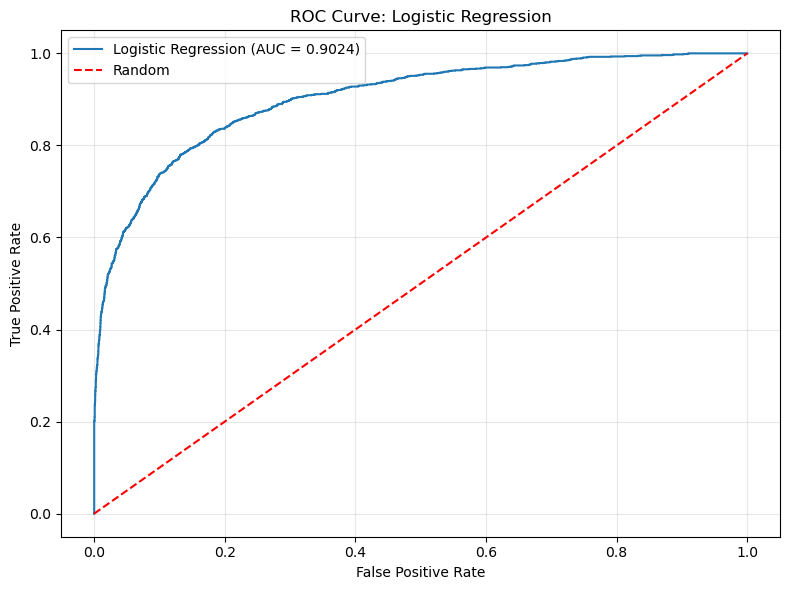


 Linear SVM...

 Linear SVM Performance:
Accuracy:  0.8311
Precision: 0.5773
Recall:    0.8143
F1-Score:  0.6756
Sensitivity: 0.8143
Specificity: 0.8357
ROC AUC:   0.9023
KL Divergence: 0.019812

Confusion Matrix:
[[4033  793]
 [ 247 1083]]


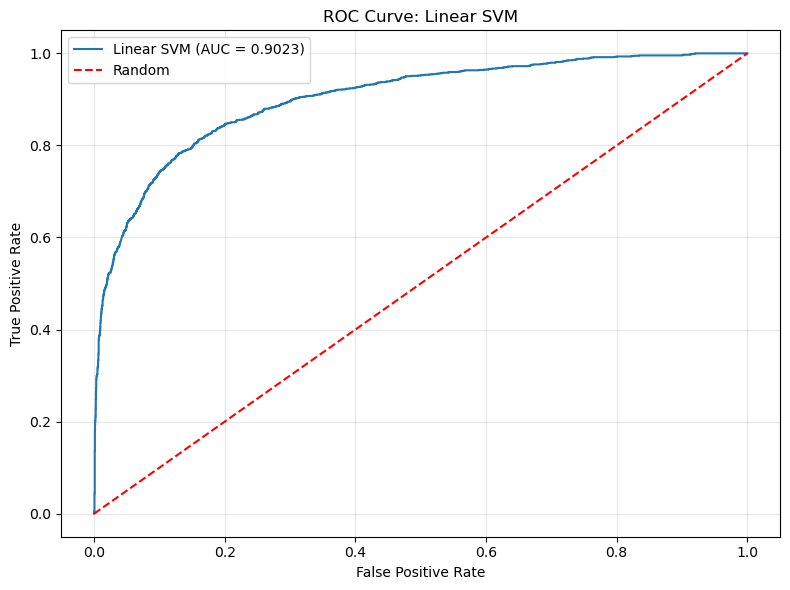


 Kernel SVM (RBF)...

 Kernel SVM Performance:
Accuracy:  0.8891
Precision: 0.7233
Recall:    0.7880
F1-Score:  0.7542
Sensitivity: 0.7880
Specificity: 0.9169
ROC AUC:   0.9165
KL Divergence: 0.001059

Confusion Matrix:
[[4425  401]
 [ 282 1048]]


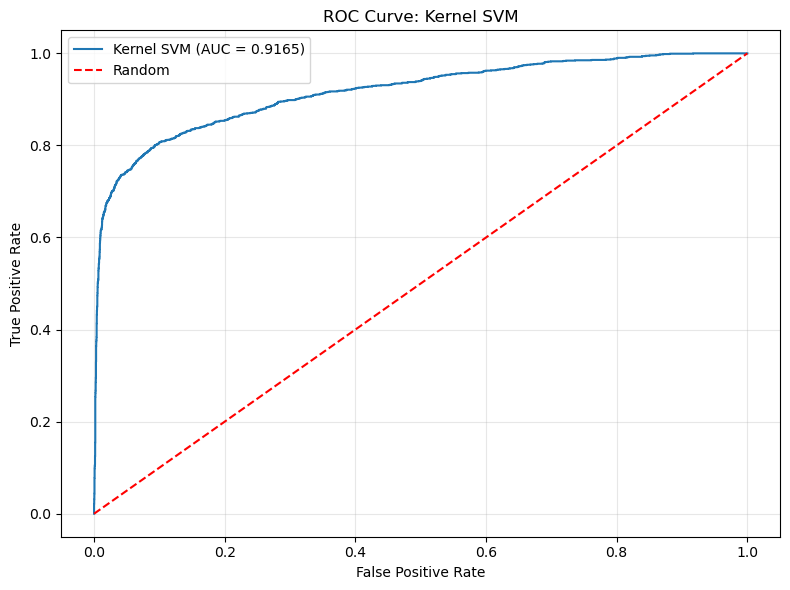


 Naive Bayes...

 Naive Bayes Performance:
Accuracy:  0.8215
Precision: 0.7895
Recall:    0.2368
F1-Score:  0.3644
Sensitivity: 0.2368
Specificity: 0.9826
ROC AUC:   0.8323
KL Divergence: 0.121830

Confusion Matrix:
[[4742   84]
 [1015  315]]


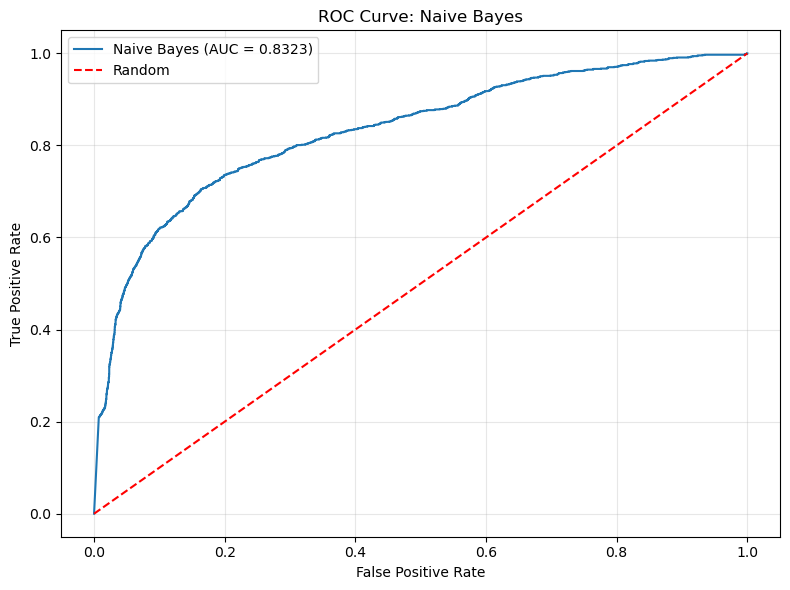

In [25]:
# Baseline Models

results = []

print("TRAINING BASELINE CLASSIFIERS")
print("="*60)

# LOGISTIC REGRESSION
print("\n Logistic Regression...")
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(
    penalty='l2', 
    C=1.0, 
    class_weight=class_weight_dict,
    random_state=42,
    max_iter=1000
)
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)
y_proba_log = logreg.predict_proba(X_test)[:, 1]
results.append(evaluate_classification(y_test, y_pred_log, y_proba_log, "Logistic Regression"))
plot_roc_curve(y_test, y_proba_log, "Logistic Regression")

# SVM (Linear)
print("\n Linear SVM...")
from sklearn.svm import SVC

svm_linear = SVC(
    kernel='linear',
    C=1.0,
    class_weight=class_weight_dict,
    probability=True,
    random_state=42
)
svm_linear.fit(X_train, y_train)
y_pred_svml = svm_linear.predict(X_test)
y_proba_svml = svm_linear.predict_proba(X_test)[:, 1]
results.append(evaluate_classification(y_test, y_pred_svml, y_proba_svml, "Linear SVM"))
plot_roc_curve(y_test, y_proba_svml, "Linear SVM")

# KERNEL SVM (RBF)
print("\n Kernel SVM (RBF)...")
svm_rbf = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    class_weight=class_weight_dict,
    probability=True,
    random_state=42
)
svm_rbf.fit(X_train, y_train)
y_pred_svmr = svm_rbf.predict(X_test)
y_proba_svmr = svm_rbf.predict_proba(X_test)[:, 1]
results.append(evaluate_classification(y_test, y_pred_svmr, y_proba_svmr, "Kernel SVM"))
plot_roc_curve(y_test, y_proba_svmr, "Kernel SVM")

# NAIVE BAYES
print("\n Naive Bayes...")
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_nb = gnb.predict(X_test)
y_proba_nb = gnb.predict_proba(X_test)[:, 1]
results.append(evaluate_classification(y_test, y_pred_nb, y_proba_nb, "Naive Bayes"))
plot_roc_curve(y_test, y_proba_nb, "Naive Bayes")


Now lets tune the main hyperparameters:

- KNN: tune k using the validation set.

- Decision Tree: tune max_depth to avoid overfitting.

- Random Forest: reuse the tuned depth from Decision Tree and build an ensemble.

After tuning, I evaluate and plot ROC curves again. For the Decision Tree, I visualize the tree to see what features it’s splitting on.


TRAINING TUNED MODELS

 K-Nearest Neighbors (Tuning K)...


  File "C:\Users\Pouyan\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Pouyan\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Pouyan\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Pouyan\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


  K=3  → Val Accuracy: 0.8775
  K=5  → Val Accuracy: 0.8803
  K=7  → Val Accuracy: 0.8852
  K=9  → Val Accuracy: 0.8876
  K=11 → Val Accuracy: 0.8869
  K=15 → Val Accuracy: 0.8865
  K=21 → Val Accuracy: 0.8830
 Best K: 9 (Val Accuracy: 0.8876)

 KNN (K=9) Performance:
Accuracy:  0.8842
Precision: 0.8776
Recall:    0.5391
F1-Score:  0.6679
Sensitivity: 0.5391
Specificity: 0.9793
ROC AUC:   0.8720
KL Divergence: 0.026085

Confusion Matrix:
[[4726  100]
 [ 613  717]]


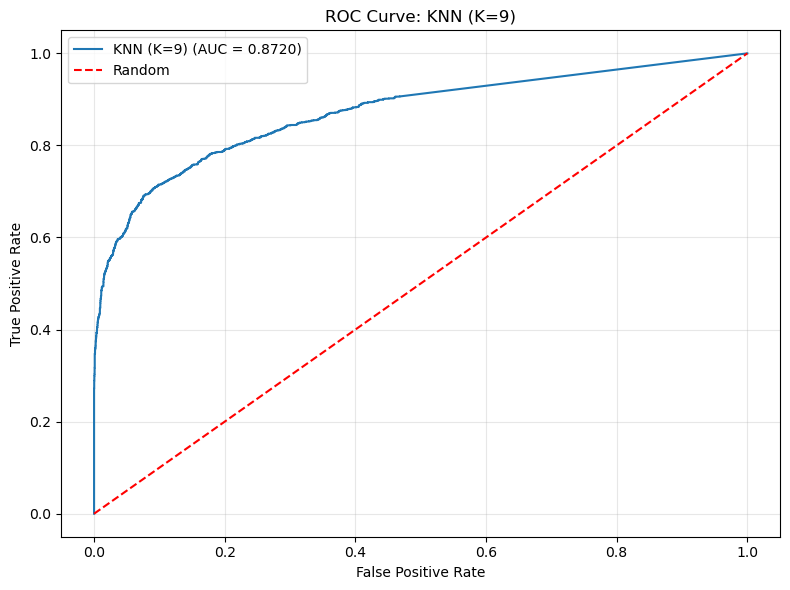


 Decision Tree (Tuning max_depth)...
  max_depth=3    → Val Accuracy: 0.8761
  max_depth=5    → Val Accuracy: 0.9025
  max_depth=7    → Val Accuracy: 0.9134
  max_depth=10   → Val Accuracy: 0.9258
  max_depth=15   → Val Accuracy: 0.8835
  max_depth=20   → Val Accuracy: 0.8863
  max_depth=None → Val Accuracy: 0.8923
 Best max_depth: 10 (Val Accuracy: 0.9258)

 Decision Tree (depth=10) Performance:
Accuracy:  0.9280
Precision: 0.9080
Recall:    0.7421
F1-Score:  0.8167
Sensitivity: 0.7421
Specificity: 0.9793
ROC AUC:   0.9075
KL Divergence: 0.005078

Confusion Matrix:
[[4726  100]
 [ 343  987]]


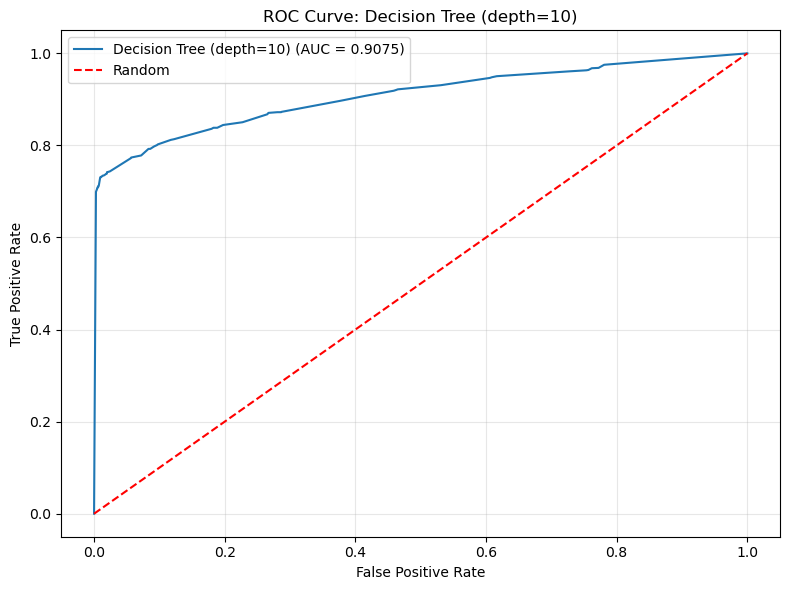

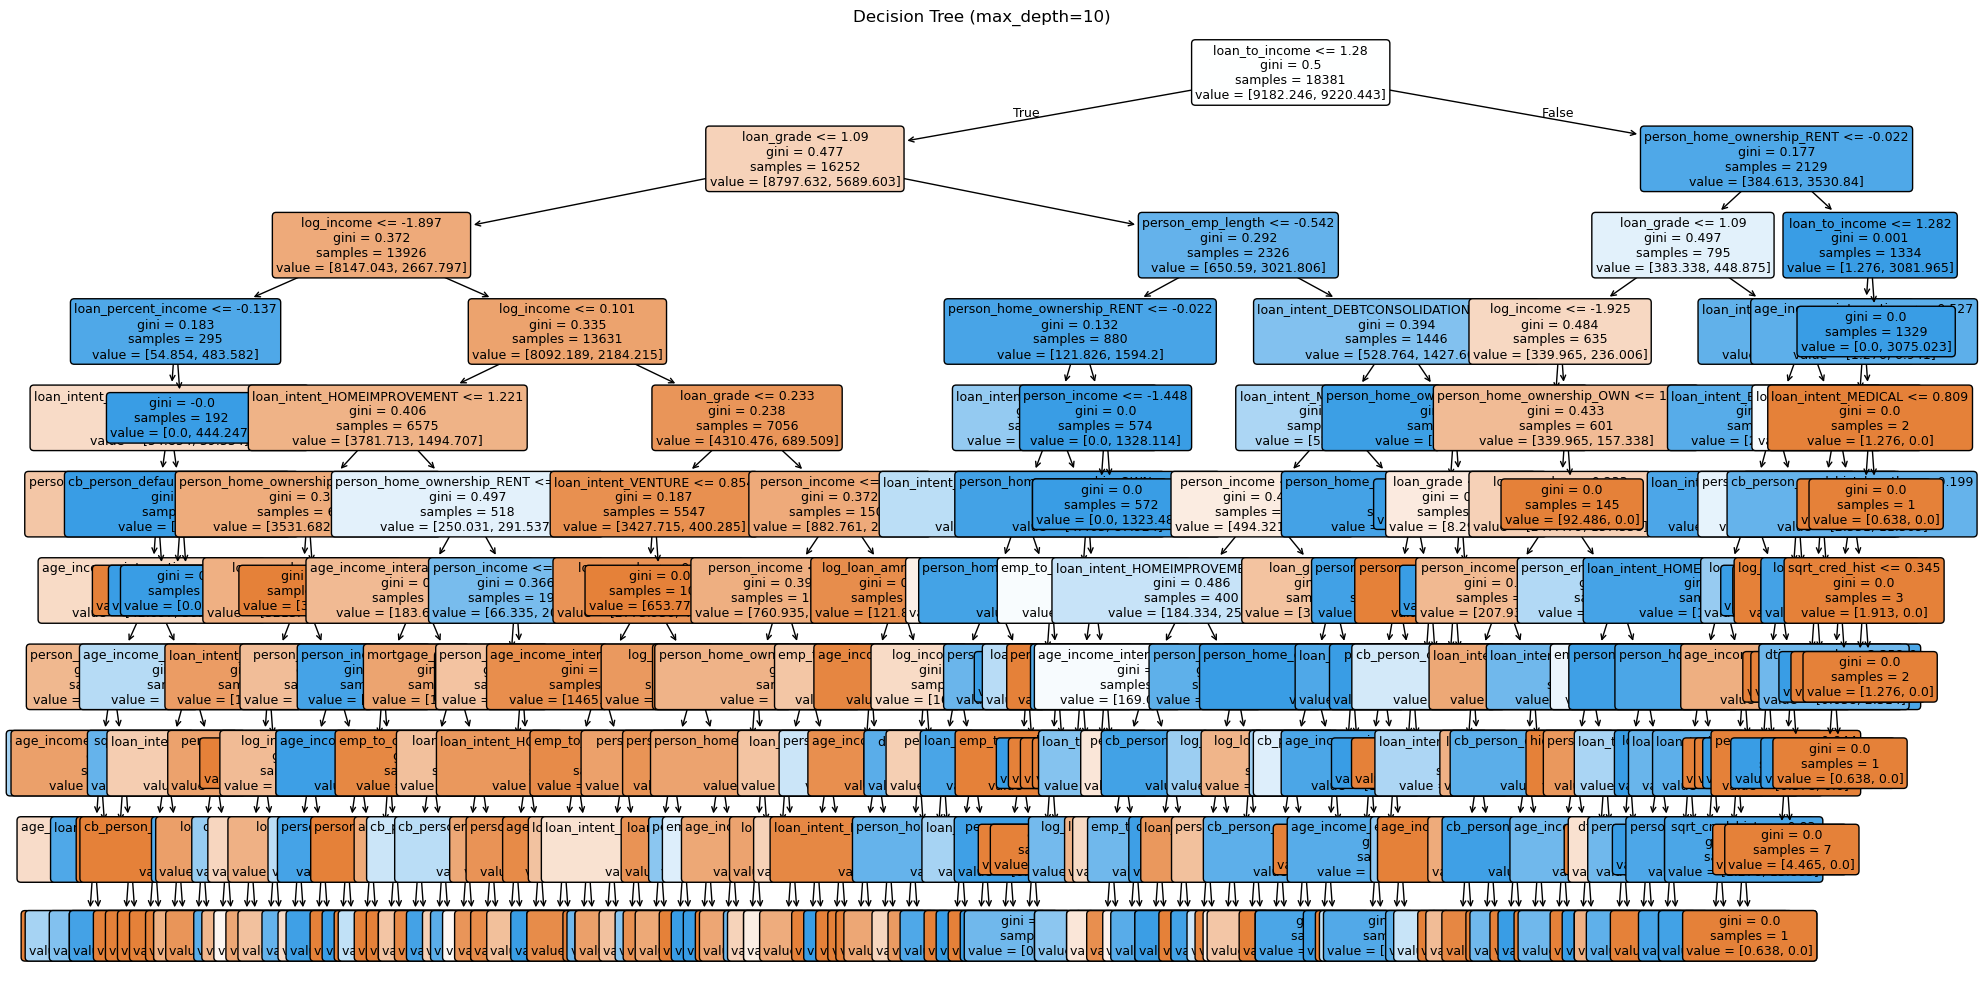


 Random Forest...

 Random Forest Performance:
Accuracy:  0.9238
Precision: 0.8806
Recall:    0.7489
F1-Score:  0.8094
Sensitivity: 0.7489
Specificity: 0.9720
ROC AUC:   0.9293
KL Divergence: 0.003339

Confusion Matrix:
[[4691  135]
 [ 334  996]]


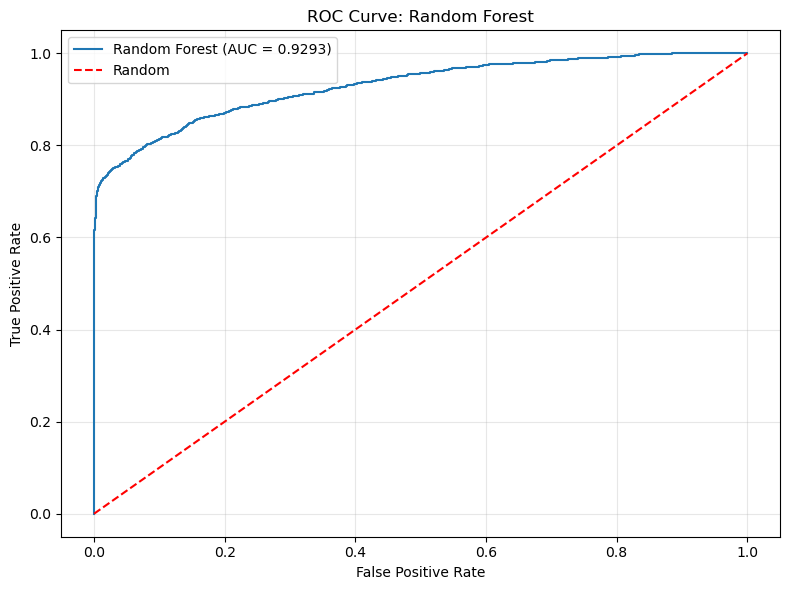

In [27]:
# Hyperparameter Tuned Models

print("\n" + "="*60)
print("TRAINING TUNED MODELS")
print("="*60)

# KNN (Tuned K)
print("\n K-Nearest Neighbors (Tuning K)...")
from sklearn.neighbors import KNeighborsClassifier

# Tune K on VAL set
best_k = None
best_val_score = 0

for k in [3, 5, 7, 9, 11, 15, 21]:
    knn_temp = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn_temp.fit(X_train, y_train)
    val_score = knn_temp.score(X_val, y_val)
    print(f"  K={k:<2} → Val Accuracy: {val_score:.4f}")
    
    if val_score > best_val_score:
        best_val_score = val_score
        best_k = k

print(f" Best K: {best_k} (Val Accuracy: {best_val_score:.4f})")

knn = KNeighborsClassifier(n_neighbors=best_k, weights='distance')
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
y_proba_knn = knn.predict_proba(X_test)[:, 1]
results.append(evaluate_classification(y_test, y_pred_knn, y_proba_knn, f"KNN (K={best_k})"))
plot_roc_curve(y_test, y_proba_knn, f"KNN (K={best_k})")

# DECISION TREE
print("\n Decision Tree (Tuning max_depth)...")
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Tune depth on VAL set
best_depth = None
best_val_score = 0

for depth in [3, 5, 7, 10, 15, 20, None]:
    dt_temp = DecisionTreeClassifier(
        max_depth=depth,
        class_weight=class_weight_dict,
        random_state=42
    )
    dt_temp.fit(X_train, y_train)
    val_score = dt_temp.score(X_val, y_val)
    print(f"  max_depth={str(depth):<4} → Val Accuracy: {val_score:.4f}")
    
    if val_score > best_val_score:
        best_val_score = val_score
        best_depth = depth

print(f" Best max_depth: {best_depth} (Val Accuracy: {best_val_score:.4f})")

dt = DecisionTreeClassifier(
    max_depth=best_depth,
    class_weight=class_weight_dict,
    random_state=42
)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
y_proba_dt = dt.predict_proba(X_test)[:, 1]
results.append(evaluate_classification(y_test, y_pred_dt, y_proba_dt, f"Decision Tree (depth={best_depth})"))
plot_roc_curve(y_test, y_proba_dt, f"Decision Tree (depth={best_depth})")

# Visualize final tree
plt.figure(figsize=(20, 10))
plot_tree(dt, feature_names=feature_names, filled=True, rounded=True, fontsize=9)
plt.title(f"Decision Tree (max_depth={best_depth})")
plt.tight_layout()
plt.show()

# RANDOM FOREST
print("\n Random Forest...")
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=best_depth,  # Reuse tuned depth
    class_weight=class_weight_dict,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]
results.append(evaluate_classification(y_test, y_pred_rf, y_proba_rf, "Random Forest"))
plot_roc_curve(y_test, y_proba_rf, "Random Forest")

 FINAL MODEL COMPARISON
                   Model  Accuracy  Precision  Recall  F1-Score    AUC  KLDivergence
     Logistic Regression    0.8272     0.5707  0.8075    0.6687 0.9024        0.0202
              Linear SVM    0.8311     0.5773  0.8143    0.6756 0.9023        0.0198
              Kernel SVM    0.8891     0.7233  0.7880    0.7542 0.9165        0.0011
             Naive Bayes    0.8215     0.7895  0.2368    0.3644 0.8323        0.1218
               KNN (K=9)    0.8842     0.8776  0.5391    0.6679 0.8720        0.0261
Decision Tree (depth=10)    0.9280     0.9080  0.7421    0.8167 0.9075        0.0051
           Random Forest    0.9238     0.8806  0.7489    0.8094 0.9293        0.0033


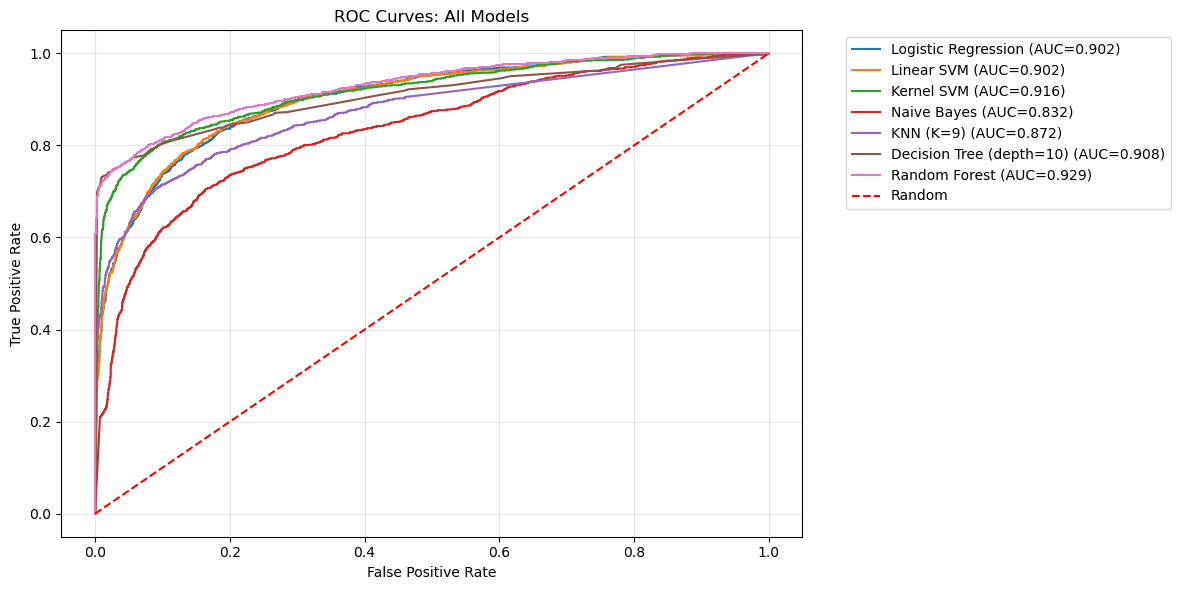


 Best Model per Metric:
  Accuracy: Decision Tree (depth=10)
  Precision: Decision Tree (depth=10)
  Recall: Linear SVM
  F1-Score: Decision Tree (depth=10)
  AUC: Random Forest


In [29]:
# Final Comparison

print(" FINAL MODEL COMPARISON")
print("="*60)
results_df = pd.DataFrame(results)
print(results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC', 'KLDivergence']].round(4).to_string(index=False))

# Plot AUC comparison using stored probabilities
plt.figure(figsize=(12, 6))

# Create mapping of model names to their probability variables
proba_mapping = {
    "Logistic Regression": y_proba_log,
    "Linear SVM": y_proba_svml,
    "Kernel SVM": y_proba_svmr,
    "Naive Bayes": y_proba_nb,
    f"KNN (K={best_k})": y_proba_knn,
    f"Decision Tree (depth={best_depth})": y_proba_dt,
    "Random Forest": y_proba_rf
}

# Plot each ROC curve
for i, row in enumerate(results):
    model_name = row['Model']
    if model_name in proba_mapping:
        fpr, tpr, _ = roc_curve(y_test, proba_mapping[model_name])
        plt.plot(fpr, tpr, label=f"{model_name} (AUC={row['AUC']:.3f})")

plt.plot([0, 1], [0, 1], 'r--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: All Models')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Best as metric
print("\n Best Model per Metric:")
best_metrics = {
    'Accuracy': results_df.loc[results_df['Accuracy'].idxmax(), 'Model'],
    'Precision': results_df.loc[results_df['Precision'].idxmax(), 'Model'],
    'Recall': results_df.loc[results_df['Recall'].idxmax(), 'Model'],
    'F1-Score': results_df.loc[results_df['F1-Score'].idxmax(), 'Model'],
    'AUC': results_df.loc[results_df['AUC'].idxmax(), 'Model']
}
for metric, model in best_metrics.items():
    print(f"  {metric}: {model}")

In here I analyze which features matter most for the tree-based models. For Decision Tree and Random Forest, I print the top 5 features and visualize the top 10 in bar plots. This helps me understand what the models are actually using to make decisions, which is crucial for interpretability in lending.

 FEATURE IMPORTANCE ANALYSIS

 Decision Tree Top 5:
loan_grade                    0.3402
loan_to_income                0.2744
log_income                    0.1234
person_home_ownership_RENT    0.0656
person_income                 0.0329
dtype: float64

 Random Forest Top 5:
loan_grade             0.2481
loan_to_income         0.0885
dti_squared            0.0802
loan_percent_income    0.0753
log_income             0.0725
dtype: float64


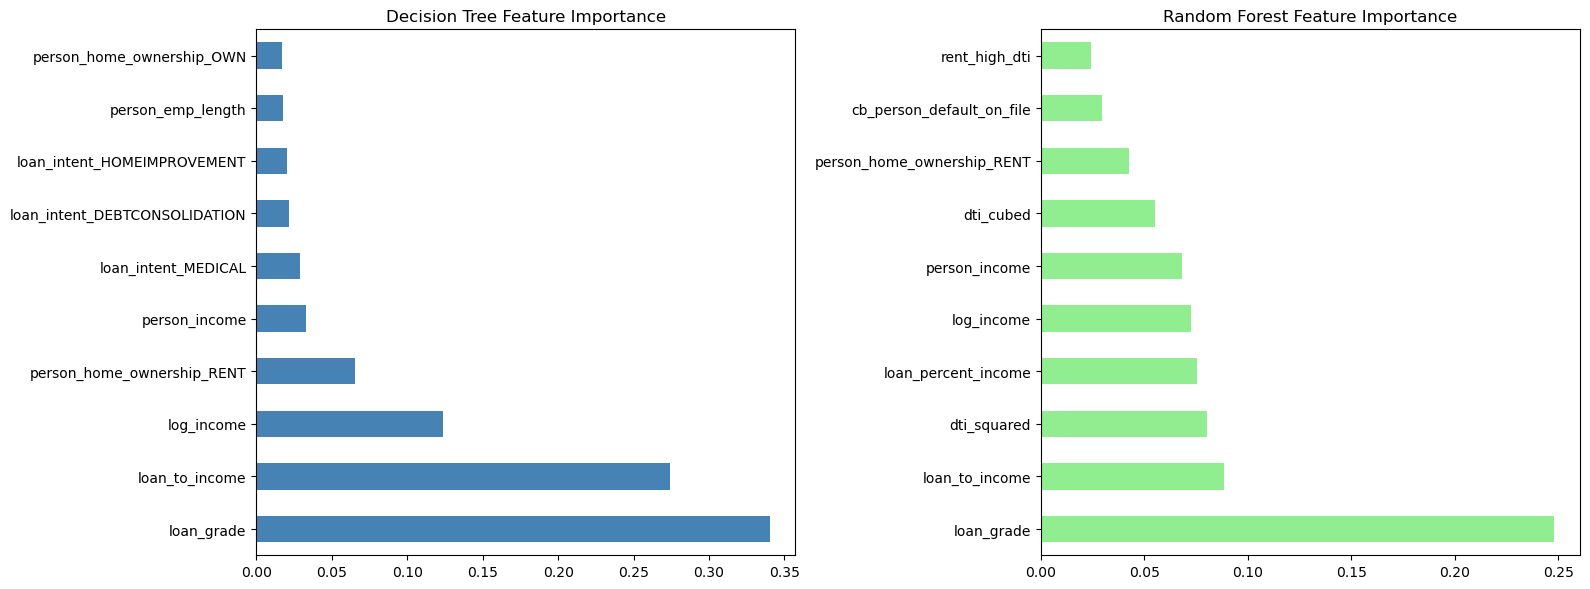

In [31]:
# Feature Importancve

print(" FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Decision Tree importance
dt_importance = pd.Series(dt.feature_importances_, index=feature_names).sort_values(ascending=False)
print("\n Decision Tree Top 5:")
print(dt_importance.head().round(4))

# Random Forest importance
rf_importance = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)
print("\n Random Forest Top 5:")
print(rf_importance.head().round(4))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
dt_importance.head(10).plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Decision Tree Feature Importance')
rf_importance.head(10).plot(kind='barh', ax=axes[1], color='lightgreen')
axes[1].set_title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

CONFUSION MATRICES


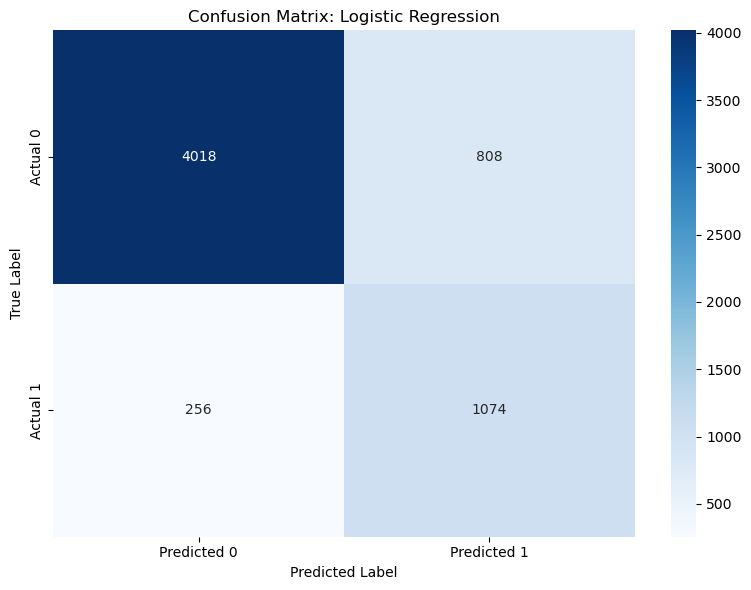

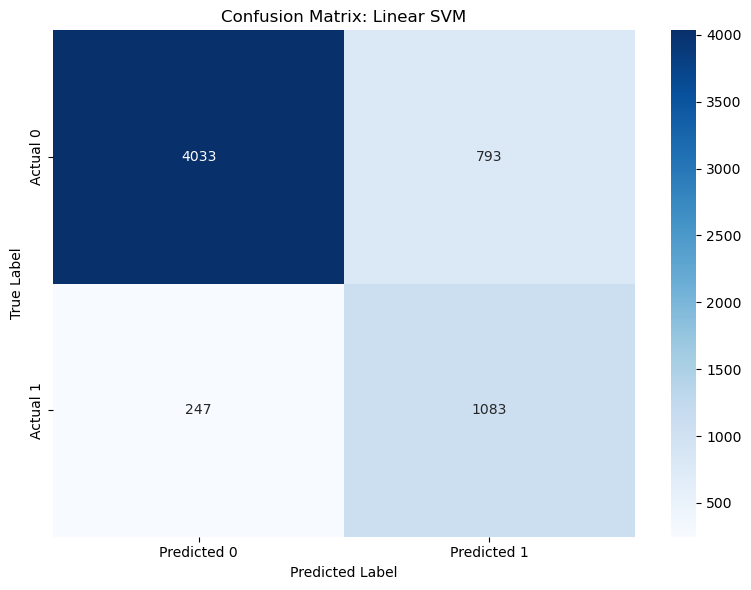

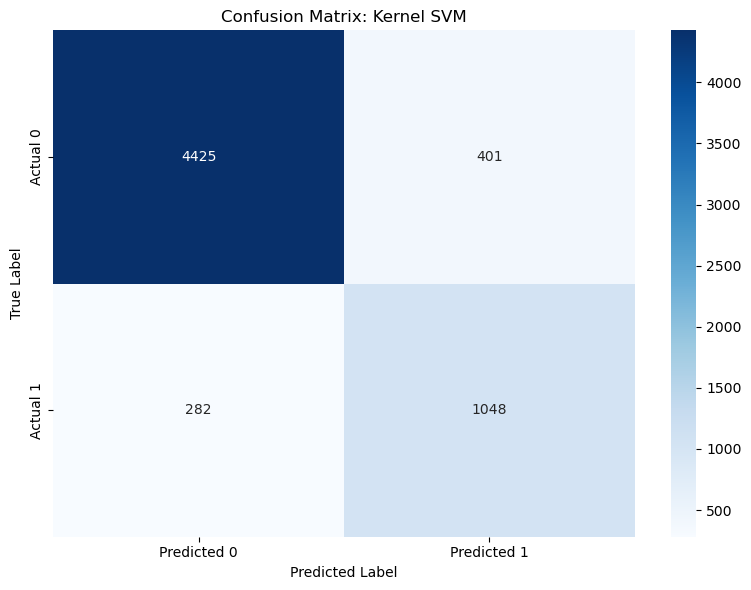

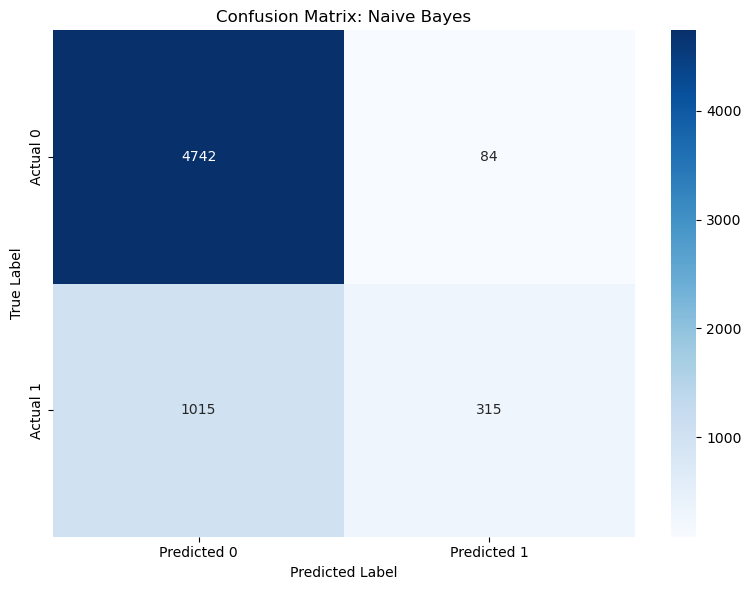

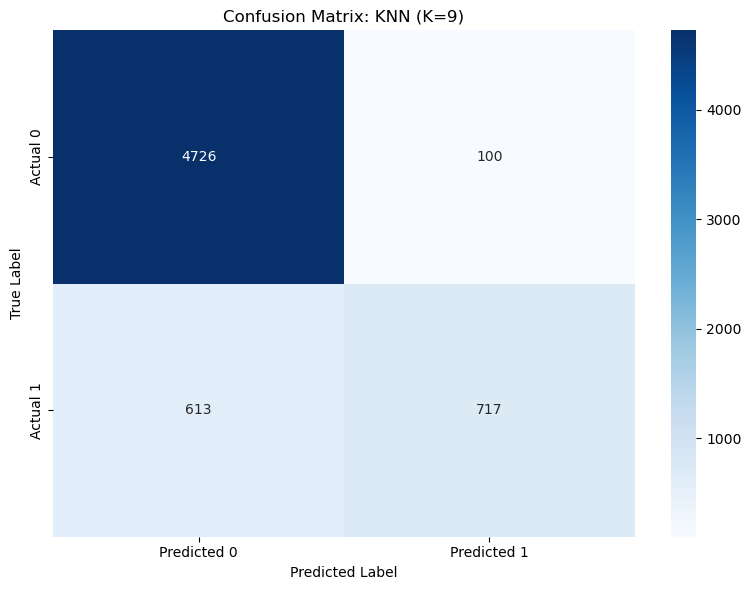

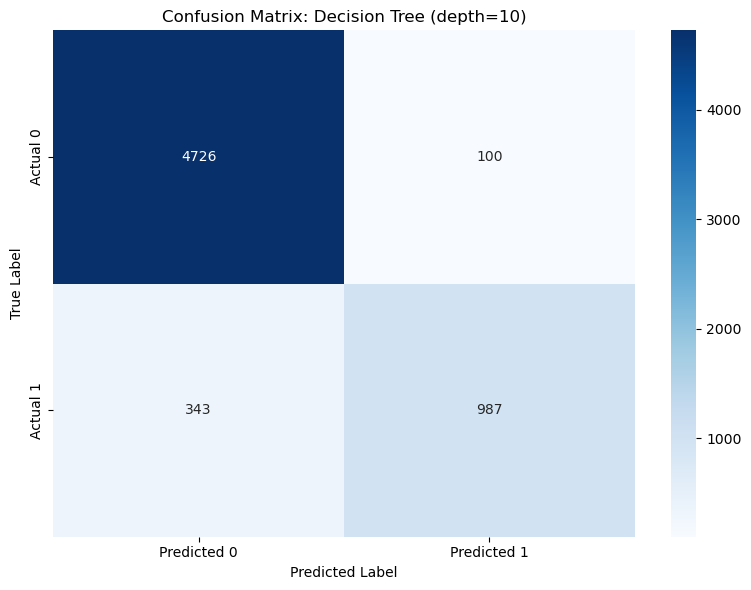

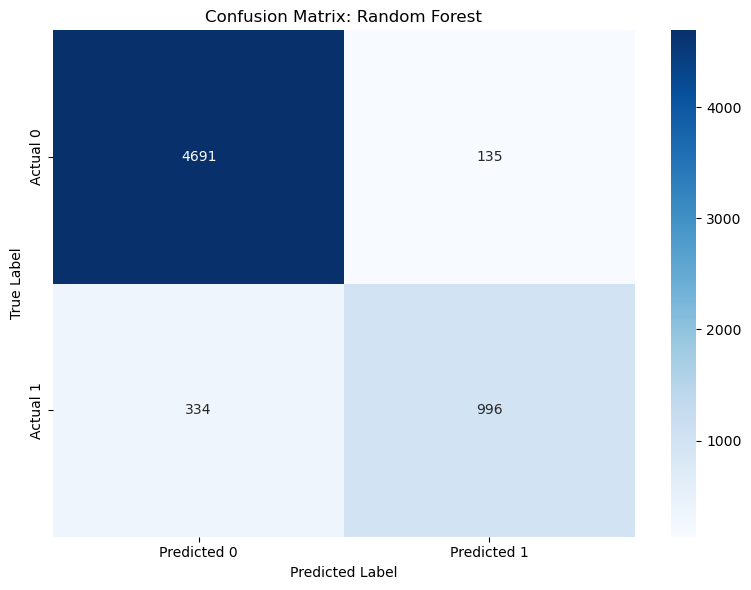


 Classification modeling complete!


In [33]:
# Confusion Matrix

def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix: {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

print("CONFUSION MATRICES")
print("="*60)

for result in results:
    plot_confusion_matrix(result['ConfusionMatrix'], result['Model'])

print("\n Classification modeling complete!")

### Best Classification Metric for Our Dataset

After evaluating all models, the metric that best reflects performance for our credit risk classification task I think is **F1-Score**. Here’s why:

1. **Imbalanced Classes:** Our dataset has unequal representation of classes, and both false positives (predicting default when there isn’t one) and false negatives (missing a default) carry real business costs. F1-Score balances **precision** (how many predicted positives are actually positive) and **recall** (how many actual positives we capture), which is ideal for imbalanced datasets.

2. **Why Not Accuracy Alone:** Accuracy is high for most models, but it can be misleading if the model just predicts the majority class well. For example, KNN achieves 88.4% accuracy but its recall is only 53.9%, meaning it misses almost half of the defaults.

3. **Why Not Precision or Recall Alone:** Precision alone would favor models that rarely predict defaults (low risk of false alarms) and recall alone would favor models that predict almost everything as default (catch all positives but lots of false alarms) however F1-Score balances both.

4. **Model Comparison Using F1-Score:**  
   - Decision Tree (depth=10): F1 = **0.8167**  
   - Random Forest: F1 = 0.8094  
   - Kernel SVM: F1 = 0.7542  
   The **Decision Tree** achieves the highest F1, indicating it best balances catching defaults while minimizing false alarms.

5. **Business Interpretation:** Using F1 ensures the model not only identifies risky loans effectively but also avoids flagging too many safe loans unnecessarily, which aligns with the operational goals of a lending institution.

**Conclusion:**  
For our credit risk dataset, **F1-Score** is the most meaningful metric because it balances sensitivity to defaults and precision of predictions.


### 3 Techniques to Regularize Decision Trees

1. **Limit Tree Depth (`max_depth`)**  
   - Restricts how deep the tree can grow prevents it from memorizing every small pattern in the training data.  
   - Shallow trees focus on the most important splits, they capture the main signal while ignoring noise.  
   - In practice, I tune `max_depth` on a validation set to find the sweet spot between bias and variance.

2. **Minimum Samples per Leaf (`min_samples_leaf`)**  
   - By forcing each leaf to have a minimum number of samples, we avoid creating tiny leaves that only fit outliers.  
   - This encourages the tree to make splits that generalize across multiple samples rather than overfitting rare cases.  
   - Works well when the dataset has some noisy or rare observations.

3. **Minimum Samples per Split (`min_samples_split`)**  
   - This sets the minimum number of samples a node must have before it can be split further.  
   - It prevents the tree from splitting too aggressively on small sample subsets, reducing overfitting.  
   - Essentially, it makes the tree more conservative in creating new branches.

### Linear SVM vs Kernel SVM

Support Vector Machines (SVMs) can be applied in different ways depending on the data:

1. **Linear SVM**  
   - this one finds a straight hyperplane that separates classes.  
   - Works well when the classes are roughly linearly separable.  
   - Fast to train, fewer hyperparameters, and easy to interpret.  
   - Limitation:it struggles when the decision boundary is complex or non-linear.

2. **Kernel SVM (RBF)**  
   - Uses a kernel trick to map data into a higher-dimensional space where it can become linearly separable.  
   - Handles complex, non-linear patterns that Linear SVM can’t capture.  
   - More flexible and often achieves higher accuracy on complicated datasets.  
   - Limitation: slower to train, sensitive to hyperparameters (`C`, `gamma`), and less interpretable.

# Work Report: Credit Risk Multiclass Classification notebook

##  Core Challenge: Multiclass Leakage & Imbalance

### Primary challenges
- **Proxy leakage:** `loan_int_rate` (rate-based) and `loan_status` (default-based) are deterministically linked to `loan_grade` through lender risk models.  
- **Class imbalance:** Grade A loans are roughly 5× more common than Grade G, requiring stratification and class weights.  
- **Categorical explosion:** One-hot encoding of `loan_intent` and `person_home_ownership` increases dimensionality from 19 → 27 features.
---

##  Step-by-Step Process & Justifications

### Step 1: Global Cleaning (Full Dataset)
**Actions**
- Dropped missing `loan_grade` rows.  
- Removed physically impossible records (e.g., employment length exceeding possible lifetime experience, unrealistic ages).  
- Filtered extreme DTI values and removed duplicates.

**Justification**  
Domain-knowledge filters must occur before splitting, since impossibilities are not dependent on train/test assignment.

---

### Step 2: Multiclass Stratified Split
**Actions**
- Performed 60%/20%/20% train/validation/test split.  
- Ensured stratification on the 7-class `loan_grade` distribution.  

**Justification**  
Stratification avoids class starvation (Grade G becoming underrepresented).  
A dedicated validation set is required for hyperparameter tuning; test data must remain untouched.

---

### Step 3: Imputation (Training Data Only)
**Actions**
- Created age brackets.  
- Computed median employment length per bracket from *training only*.  
- Applied these medians to all data splits.

**Justification**  
Employment length correlates with age but not with grade.  
Using training statistics avoids test set leakage.

---

### Step 4: Target Encoding (Critical Fix)
**Actions**
- Integer-encoded grade classes in the order A → G.  
- Stored encoder for later decoding of predictions back to letter grades.

**Justification**  
Boosting libraries require numeric class labels.  
Ordinal ordering allows compatibility with ordinal-aware metrics.

---

### Step 5: One-Hot Encoding (Requested Change)
**Actions**
- One-hot encoded `person_home_ownership` and `loan_intent`.  
- Increased feature count from 19 → 27.

**Justification**  
- Improves linear model behavior.  
- Increases dimensionality, requiring deeper trees.  
- Forces more aggressive scaling due to categorical variance.

---

### **Step 6: Feature Engineering (Post-Encoding, Pre-Scaling)**

#### **Features Created**
- `log_income` — Log-transform of income for variance reduction.  
- `log_loan_amnt` — Log-transform of loan amount (important for tree + linear models).  
- `loan_to_income` — Measures borrower leverage.  
- `dti_squared`, `dti_cubed` — Non-linear expansions of DTI; useful for SVM/RBF, boosting.  
- `sqrt_cred_hist` — Diminishing returns transformation of credit history length.  
- `emp_to_cred_ratio` — Employment stability relative to credit depth.  
- `high_risk_flag` — *(loan_percent_income > 0.4)* AND *(past default)* → strong risk classifier.  
- `rent_high_dti` — Renting + high DTI → risky segment.  
- `mortgage_low_dti` — Mortgage + low DTI → protective segment.  
- `age_income_interaction` — Captures life-cycle income profiles.

---

#### **Justification**
- **No leakage**: All variables come from borrower application data only.  
- **High-risk interaction flags** combine weak predictors into strong ones (critical for classification).  
- **Non-linear DTI transforms** help both linear and non-linear models capture curvature.  
- **Log and sqrt transforms** stabilize extreme values and improve gradient-based learning.

---

### Step 7: Outlier Detection (Training Threshold, Flag All)
**Actions**
- Calculated outlier thresholds from training distribution.  
- Removed extreme cases from training only.  
- Flagged but retained outliers in validation and test sets.

**Justification**  
Real-world production scenarios require models to handle outliers; hiding them during evaluation would inflate performance.

---

### Step 8: Scaling (Mandatory for Linear Models & SVM)
**Actions**
- Standardized using training-only statistics.  
- Applied scaling consistently across splits.

**Justification**  
One-hot columns have fixed variance, while continuous features vary widely.  
Scaling ensures meaningful regularization and stable optimization.

---

### Step 9: Persistence (Separate from Regression)
**Artifacts saved**
- Processed training arrays  
- Feature name mappings  
- Target encoder  
- Cleaned final CSV  

**Justification**  
The `_multiclass` suffix prevents collisions with other pipeline outputs (regression, binary classification).

---

## Challenges Encountered & Solutions

### Challenge 1: CatBoost Depth Limit
- **Issue:** Maximum depth capped at 16.  
- **Solution:** Constrained best-found depth to library limits.
  
### Challenge 2: One-Hot Dimensionality Explosion
- **Issue:** Feature count jumped from 19 to 27.  
- **Solution:** Increased tree depth to compensate for diluted importance per feature.  

### Challenge 3: Multiclass ROC Visualization
- **Issue:** ROC cannot be drawn as a single curve for 7 classes.  
- **Solution:** Use one-vs-rest ROC curves (one per class).  

---


In [35]:
import numpy as np
import pandas as pd
import joblib
import os
import zipfile
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score,  
    f1_score,
    confusion_matrix, 
    cohen_kappa_score, 
    log_loss,
    roc_auc_score,
    roc_curve
)

In [37]:
# get Data

GDRIVE_FILE_ID = "1znbtH_keDDPDvcjHRIXAF5bZuXJtId1F"  

SUFFIX = '_multiclass'

# Check if files already exist
if not os.path.exists(f'X_train{SUFFIX}.npy'):
    print(" Downloading artifacts...")
    
    # Install gdown if needed
    try:
        import gdown
    except ImportError:
        os.system('pip install gdown -q')
        import gdown
    
    gdown.download(
        f'https://drive.google.com/uc?id={GDRIVE_FILE_ID}', 
        'multiclass_artifacts.zip', 
        quiet=False
    )
    
    with zipfile.ZipFile('multiclass_artifacts.zip', 'r') as zipf:
        zipf.extractall('.')
    os.remove('multiclass_artifacts.zip')
    print(" Extraction complete!")
else:
    print(" Artifacts already present")

# Load

X_train = np.load(f'X_train{SUFFIX}.npy')
X_val = np.load(f'X_val{SUFFIX}.npy')
X_test = np.load(f'X_test{SUFFIX}.npy')
y_train = np.load(f'y_train{SUFFIX}.npy')
y_val = np.load(f'y_val{SUFFIX}.npy')
y_test = np.load(f'y_test{SUFFIX}.npy')

feature_names = np.load(f'feature_names{SUFFIX}.npy', allow_pickle=True).tolist()
class_weights_array = np.load(f'class_weights{SUFFIX}.npy')

unique_classes = np.unique(y_train)
class_weight_dict = dict(zip(unique_classes, class_weights_array))

print(f" Loaded multiclass data")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")
print(f"Features ({len(feature_names)}): {feature_names[:5]}...")
print(f"Classes: {unique_classes}")
print(f"Class weights: {class_weight_dict}")

Downloading...
From: https://drive.google.com/uc?id=1znbtH_keDDPDvcjHRIXAF5bZuXJtId1F
To: C:\Users\Pouyan\python\ADS\multiclass_artifacts.zip
100%|██████████| 2.59M/2.59M [00:01<00:00, 1.82MB/s]


 Extraction complete!
 Loaded multiclass data
Training set: (18376, 29)
Validation set: (6156, 29)
Test set: (6156, 29)
Features (29): ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_percent_income']...
Classes: [0 1 2 3 4 5 6]
Class weights: {0: 0.4382395238569862, 1: 0.44489093826339604, 2: 0.7126186617272516, 3: 1.26637590520079, 4: 4.732892511148701, 5: 19.034013605442176, 6: 73.28095238095239}


as the code here follows the same structure and flow as part 2 I just go with executing them as no explanation is needed here.

In [39]:
# MULTICLASS EVALUATION FUNCTION

def evaluate_multiclass(y_true, y_pred, y_proba, model_name="Model"):
    """
    Compute all required multiclass metrics
    """
    # Basic metrics
    acc = accuracy_score(y_true, y_pred)
    
    # Per-class metrics (use imported recall_score)
    precision_per_class = precision_score(y_true, y_pred, average=None, labels=unique_classes)
    recall_per_class = recall_score(y_true, y_pred, average=None, labels=unique_classes)  # ✅ Now works
    
    # Aggregated F1 scores
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    
    # Kappa
    kappa = cohen_kappa_score(y_true, y_pred, labels=unique_classes)
    
    # G-Mean (geometric mean of recall per class)
    recall_per_class_arr = recall_score(y_true, y_pred, average=None, labels=unique_classes)
    g_mean = np.prod(recall_per_class_arr) ** (1 / len(unique_classes))
    
    # Log loss
    logloss = log_loss(y_true, y_proba, labels=unique_classes)
    
    print(f"\n {model_name} Performance:")
    print("="*60)
    print(f"Accuracy:          {acc:.4f}")
    print(f"F1-Macro:          {f1_macro:.4f}")
    print(f"F1-Micro:          {f1_micro:.4f}")
    print(f"F1-Weighted:       {f1_weighted:.4f}")
    print(f"Cohen's Kappa:     {kappa:.4f}")
    print(f"G-Mean:            {g_mean:.4f}")
    print(f"Log Loss:          {logloss:.4f}")
    
    # Per-class metrics
    print("\nPer-Class Metrics:")
    for i, cls in enumerate(unique_classes):
        print(f"  Class {cls}: Precision={precision_per_class[i]:.4f}, Recall={recall_per_class[i]:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=unique_classes)
    print("\nConfusion Matrix:")
    print(cm)
    
    return {
        'Model': model_name,
        'Accuracy': acc,
        'F1-Macro': f1_macro,
        'F1-Micro': f1_micro,
        'F1-Weighted': f1_weighted,
        'Kappa': kappa,
        'G-Mean': g_mean,
        'LogLoss': logloss,
        'Precision_PerClass': precision_per_class,
        'Recall_PerClass': recall_per_class,
        'ConfusionMatrix': cm,
        'y_proba': y_proba  # Store for ROC visualization
    }


In [41]:
# Base Models

results = []

print("TRAINING BASELINE MULTICLASS MODELS")
print("="*60)

# Logistic Reg (One-vs-Rest)
print("\n Logistic Regression (One-vs-Rest)...")
from sklearn.linear_model import LogisticRegression

logreg_ovr = LogisticRegression(
    penalty='l2',
    C=1.0,
    multi_class='ovr',  # One-vs-Rest
    class_weight='balanced',
    random_state=42,
    max_iter=1000
)
logreg_ovr.fit(X_train, y_train)
y_pred_log_ovr = logreg_ovr.predict(X_test)
y_proba_log_ovr = logreg_ovr.predict_proba(X_test)
results.append(evaluate_multiclass(y_test, y_pred_log_ovr, y_proba_log_ovr, "LogReg (OvR)"))

# Logistic reg (Multinomial)
print("\n Logistic Regression (Multinomial)...")
logreg_multi = LogisticRegression(
    penalty='l2',
    C=1.0,
    multi_class='multinomial', #softmax
    solver='lbfgs',
    class_weight='balanced',
    random_state=42,
    max_iter=1000
)
logreg_multi.fit(X_train, y_train)
y_pred_log_multi = logreg_multi.predict(X_test)
y_proba_log_multi = logreg_multi.predict_proba(X_test)
results.append(evaluate_multiclass(y_test, y_pred_log_multi, y_proba_log_multi, "LogReg (Multinomial)"))

# Multicalss SVM (One-vs-Rest)
print("\n Linear SVM (One-vs-Rest)...")
from sklearn.svm import SVC

svm_ovr = SVC(
    kernel='linear',
    C=1.0,
    decision_function_shape='ovr',
    class_weight='balanced',
    probability=True,
    random_state=42
)
svm_ovr.fit(X_train, y_train)
y_pred_svm_ovr = svm_ovr.predict(X_test)
y_proba_svm_ovr = svm_ovr.predict_proba(X_test)
results.append(evaluate_multiclass(y_test, y_pred_svm_ovr, y_proba_svm_ovr, "SVM (OvR)"))

# NAIVE BAYES
print("\n Naive Bayes...")
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_nb = gnb.predict(X_test)
y_proba_nb = gnb.predict_proba(X_test)
results.append(evaluate_multiclass(y_test, y_pred_nb, y_proba_nb, "Naive Bayes"))


TRAINING BASELINE MULTICLASS MODELS

 Logistic Regression (One-vs-Rest)...

 LogReg (OvR) Performance:
Accuracy:          0.4181
F1-Macro:          0.2288
F1-Micro:          0.4181
F1-Weighted:       0.4183
Cohen's Kappa:     0.2116
G-Mean:            0.1598
Log Loss:          1.6181

Per-Class Metrics:
  Class 0: Precision=0.4941, Recall=0.5436
  Class 1: Precision=0.4315, Recall=0.4937
  Class 2: Precision=0.6086, Recall=0.3768
  Class 3: Precision=0.3529, Recall=0.0346
  Class 4: Precision=0.0556, Recall=0.0161
  Class 5: Precision=0.0342, Recall=0.2826
  Class 6: Precision=0.0048, Recall=0.1667

Confusion Matrix:
[[1091  766    0    3    7   44   96]
 [ 743  976    0    0   10  104  144]
 [ 243  311  465   30   14   93   78]
 [  98  163  238   24   17   84   70]
 [  26   37   45   11    3   38   26]
 [   6    7   13    0    3   13    4]
 [   1    2    3    0    0    4    2]]

 Logistic Regression (Multinomial)...

 LogReg (Multinomial) Performance:
Accuracy:          0.3965
F1-Macr

TRAINING TUNED MODELS

 K-Nearest Neighbors (Tuning K)...
  K=3  → Val Accuracy: 0.3908
  K=5  → Val Accuracy: 0.4129
  K=7  → Val Accuracy: 0.4220
  K=9  → Val Accuracy: 0.4300
  K=11 → Val Accuracy: 0.4362
  K=15 → Val Accuracy: 0.4475
  K=21 → Val Accuracy: 0.4570
 Best K: 21 (Val Accuracy: 0.4570)

 KNN (K=21) Performance:
Accuracy:          0.4599
F1-Macro:          0.2333
F1-Micro:          0.4599
F1-Weighted:       0.4358
Cohen's Kappa:     0.2301
G-Mean:            0.0000
Log Loss:          2.5079

Per-Class Metrics:
  Class 0: Precision=0.4627, Recall=0.5845
  Class 1: Precision=0.4212, Recall=0.5316
  Class 2: Precision=0.5723, Recall=0.4392
  Class 3: Precision=0.3693, Recall=0.0937
  Class 4: Precision=0.0000, Recall=0.0000
  Class 5: Precision=0.0000, Recall=0.0000
  Class 6: Precision=0.0000, Recall=0.0000

Confusion Matrix:
[[1173  812   19    3    0    0    0]
 [ 903 1051   14    9    0    0    0]
 [ 286  344  542   61    1    0    0]
 [ 130  206  291   65    2    0    

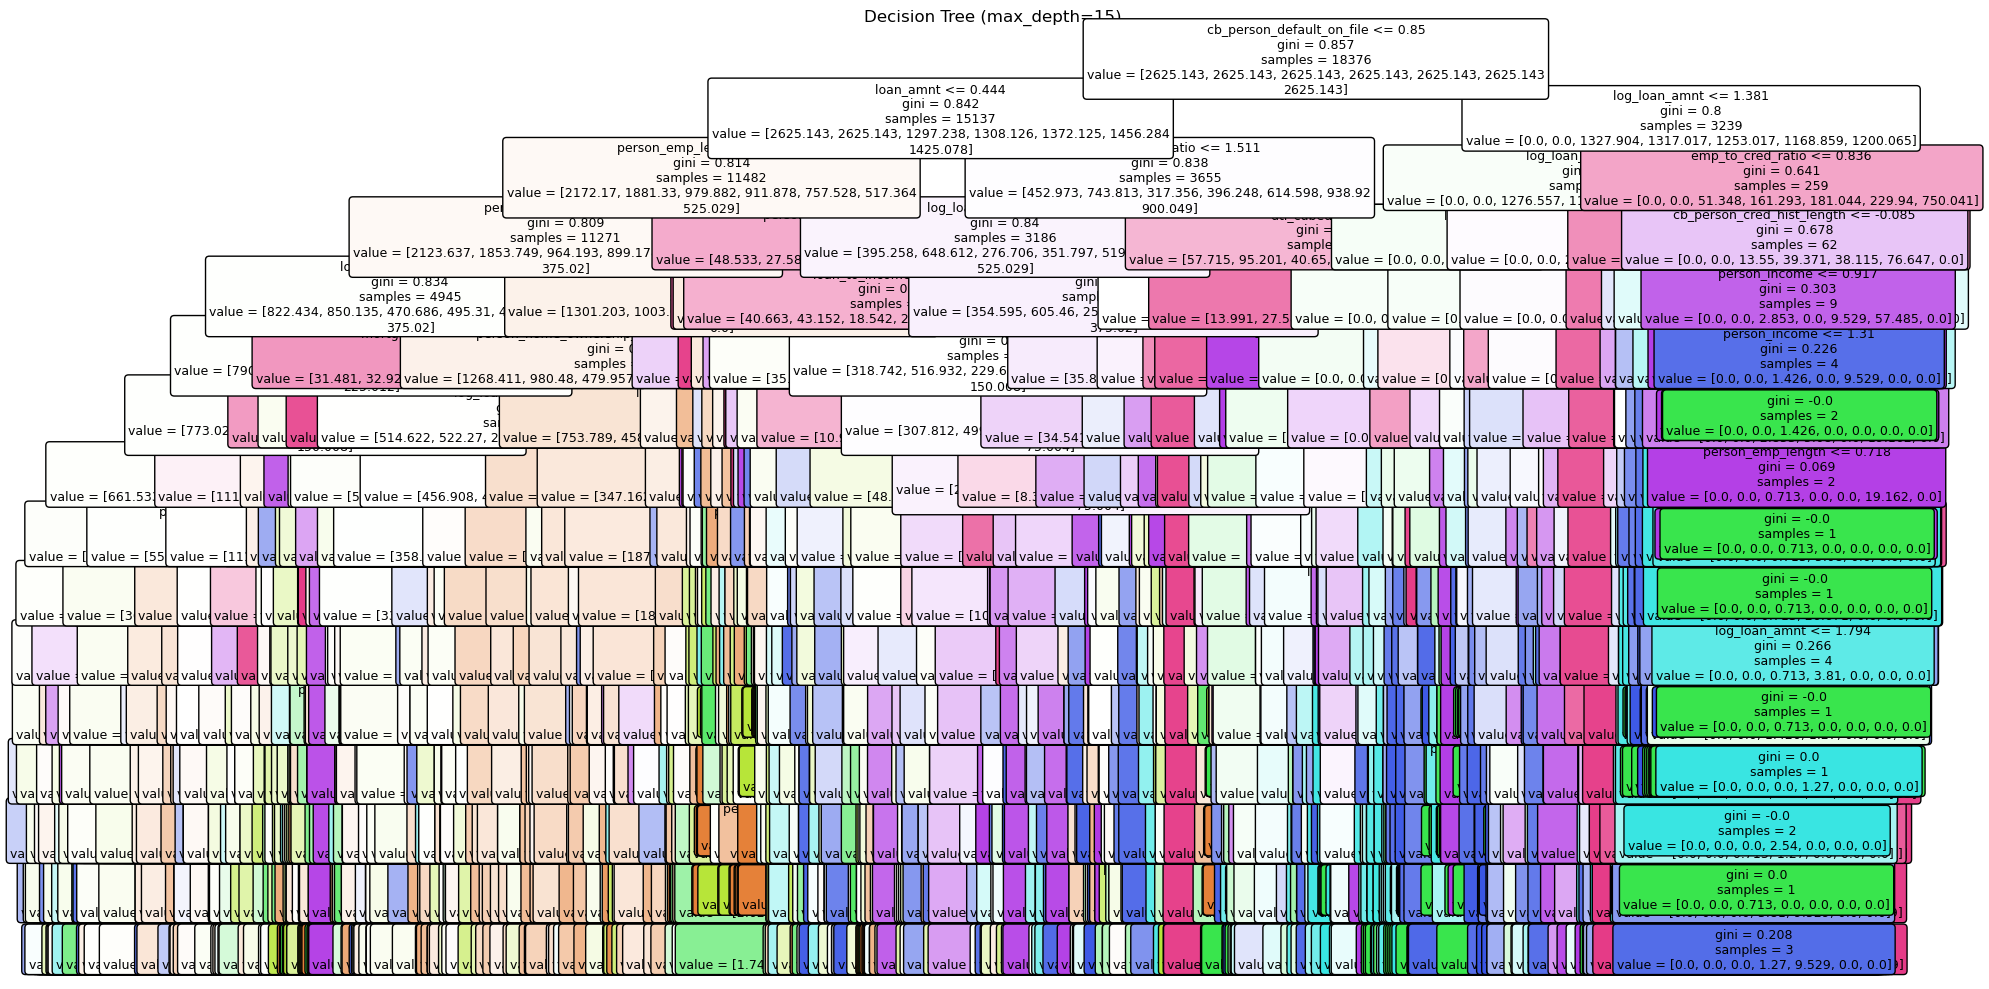


 Random Forest...

 Random Forest Performance:
Accuracy:          0.4834
F1-Macro:          0.2647
F1-Micro:          0.4834
F1-Weighted:       0.4632
Cohen's Kappa:     0.2670
G-Mean:            0.0000
Log Loss:          1.2926

Per-Class Metrics:
  Class 0: Precision=0.4886, Recall=0.6203
  Class 1: Precision=0.4540, Recall=0.5544
  Class 2: Precision=0.5809, Recall=0.4279
  Class 3: Precision=0.3929, Recall=0.1427
  Class 4: Precision=0.2500, Recall=0.0376
  Class 5: Precision=0.2000, Recall=0.0217
  Class 6: Precision=0.0000, Recall=0.0000

Confusion Matrix:
[[1245  736   15    8    3    0    0]
 [ 851 1096   14   14    1    1    0]
 [ 286  315  528   91   13    1    0]
 [ 129  185  275   99    4    2    0]
 [  28   66   59   26    7    0    0]
 [   8   12   15   10    0    1    0]
 [   1    4    3    4    0    0    0]]


In [43]:
# Models with Hyerparamether tuned

print("TRAINING TUNED MODELS")
print("="*60)

# MUulticalss KNN (Tuned K)
print("\n K-Nearest Neighbors (Tuning K)...")
from sklearn.neighbors import KNeighborsClassifier

best_k = None
best_val_score = 0

for k in [3, 5, 7, 9, 11, 15, 21]:
    knn_temp = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn_temp.fit(X_train, y_train)
    val_score = knn_temp.score(X_val, y_val)
    print(f"  K={k:<2} → Val Accuracy: {val_score:.4f}")
    
    if val_score > best_val_score:
        best_val_score = val_score
        best_k = k

print(f" Best K: {best_k} (Val Accuracy: {best_val_score:.4f})")

knn = KNeighborsClassifier(n_neighbors=best_k, weights='distance')
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
y_proba_knn = knn.predict_proba(X_test)
results.append(evaluate_multiclass(y_test, y_pred_knn, y_proba_knn, f"KNN (K={best_k})"))

# Multiclass Decision tree (Tuned max_depth)
print("\n Decision Tree (Tuning max_depth)...")
from sklearn.tree import DecisionTreeClassifier, plot_tree

best_depth = None
best_val_score = 0

for depth in [5, 10, 15, 20, None]:
    dt_temp = DecisionTreeClassifier(
        max_depth=depth,
        class_weight='balanced',
        random_state=42
    )
    dt_temp.fit(X_train, y_train)
    val_score = dt_temp.score(X_val, y_val)
    print(f"  max_depth={str(depth):<4} → Val Accuracy: {val_score:.4f}")
    
    if val_score > best_val_score:
        best_val_score = val_score
        best_depth = depth

print(f" Best max_depth: {best_depth} (Val Accuracy: {best_val_score:.4f})")

dt = DecisionTreeClassifier(
    max_depth=best_depth,
    class_weight='balanced',
    random_state=42
)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
y_proba_dt = dt.predict_proba(X_test)
results.append(evaluate_multiclass(y_test, y_pred_dt, y_proba_dt, f"Decision Tree (depth={best_depth})"))

# Visualize tree
plt.figure(figsize=(20, 10))
plot_tree(dt, feature_names=feature_names, filled=True, rounded=True, fontsize=9)
plt.title(f"Decision Tree (max_depth={best_depth})")
plt.tight_layout()
plt.show()

# RANDOM FOREST
print("\n Random Forest...")
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=best_depth,  # Reuse tuned depth
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)
results.append(evaluate_multiclass(y_test, y_pred_rf, y_proba_rf, "Random Forest"))

In [45]:
# Boosting Models (Conditional Imports)- this takes about 15 min

print("TRAINING BOOSTING MODELS")
print("="*60)

# ADABOOST
print("\n AdaBoost...")
from sklearn.ensemble import AdaBoostClassifier

adaboost = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3),
    n_estimators=100,
    learning_rate=1.0,
    random_state=42
)
adaboost.fit(X_train, y_train)
y_pred_ada = adaboost.predict(X_test)
y_proba_ada = adaboost.predict_proba(X_test)
results.append(evaluate_multiclass(y_test, y_pred_ada, y_proba_ada, "AdaBoost"))

# XGBOOST
sample_weights = np.array([class_weight_dict[y] for y in y_train])
try:
    from xgboost import XGBClassifier
    print("\n XGBoost...")
    xgb = XGBClassifier(
        n_estimators=100,
        max_depth=best_depth if best_depth else 6,
        learning_rate=0.1,
        objective='multi:softprob',
        num_class=len(unique_classes),
        eval_metric='mlogloss',
        early_stopping_rounds=20,
        use_label_encoder=False,
        random_state=42,
        n_jobs=-1
    )
    xgb.fit(
        X_train, y_train,
        sample_weight=sample_weights,  
        eval_set=[(X_val, y_val)],  
        verbose=False
    )
    y_pred_xgb = xgb.predict(X_test)
    y_proba_xgb = xgb.predict_proba(X_test)
    results.append(evaluate_multiclass(y_test, y_pred_xgb, y_proba_xgb, "XGBoost"))
except ImportError:
    print(" XGBoost not installed. Skipping...")
    results.append({'Model': 'XGBoost', 'Accuracy': np.nan, 'F1-Macro': np.nan, 'LogLoss': np.nan})

# LIGHTGBM
try:
    from lightgbm import LGBMClassifier
    print("\n LightGBM...")
    lgbm = LGBMClassifier(
        n_estimators=100,
        max_depth=best_depth if best_depth else -1,
        learning_rate=0.1,
        objective='multiclass',
        num_class=len(unique_classes),
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    lgbm.fit(X_train, y_train)
    y_pred_lgbm = lgbm.predict(X_test)
    y_proba_lgbm = lgbm.predict_proba(X_test)
    results.append(evaluate_multiclass(y_test, y_pred_lgbm, y_proba_lgbm, "LightGBM"))
except ImportError:
    print(" LightGBM not installed. Skipping...")
    results.append({'Model': 'LightGBM', 'Accuracy': np.nan, 'F1-Macro': np.nan, 'LogLoss': np.nan})

# CATBOOST
catboost_depth = min(best_depth, 16) if best_depth else 6
try:
    from catboost import CatBoostClassifier
    print("\n CatBoost...")
    catboost = CatBoostClassifier(
        iterations=100,
        depth=catboost_depth,
        learning_rate=0.1,
        loss_function='MultiClass',
        class_weights=class_weight_dict,
        verbose=False,
        random_state=42,
        thread_count=-1
    )
    catboost.fit(X_train, y_train)
    y_pred_cat = catboost.predict(X_test)
    y_proba_cat = catboost.predict_proba(X_test)
    results.append(evaluate_multiclass(y_test, y_pred_cat, y_proba_cat, "CatBoost"))
except ImportError:
    print(" CatBoost not installed. Skipping...")
    results.append({'Model': 'CatBoost', 'Accuracy': np.nan, 'F1-Macro': np.nan, 'LogLoss': np.nan})

TRAINING BOOSTING MODELS

 AdaBoost...

 AdaBoost Performance:
Accuracy:          0.4596
F1-Macro:          0.2502
F1-Micro:          0.4596
F1-Weighted:       0.4414
Cohen's Kappa:     0.2337
G-Mean:            0.0000
Log Loss:          1.9325

Per-Class Metrics:
  Class 0: Precision=0.4647, Recall=0.5994
  Class 1: Precision=0.4294, Recall=0.5154
  Class 2: Precision=0.5635, Recall=0.3955
  Class 3: Precision=0.3828, Recall=0.1671
  Class 4: Precision=0.1053, Recall=0.0108
  Class 5: Precision=1.0000, Recall=0.0217
  Class 6: Precision=0.0000, Recall=0.0000

Confusion Matrix:
[[1203  787   17    0    0    0    0]
 [ 918 1019   30    8    2    0    0]
 [ 300  303  488  131   11    0    1]
 [ 126  191  255  116    4    0    2]
 [  33   59   63   28    2    0    1]
 [   8   10   10   16    0    1    1]
 [   1    4    3    4    0    0    0]]

 XGBoost...

 XGBoost Performance:
Accuracy:          0.4711
F1-Macro:          0.2811
F1-Micro:          0.4711
F1-Weighted:       0.4602
Cohen's 

In [47]:
# final comparison

print(" FINAL MODEL COMPARISON (Multiclass)")
print("="*60)

results_df = pd.DataFrame(results)
print(results_df[['Model', 'Accuracy', 'F1-Macro', 'F1-Micro', 'F1-Weighted', 'Kappa', 'G-Mean', 'LogLoss']].round(4).to_string(index=False))

# Best per metric
print("\n Best Model per Metric:")
best_metrics = {
    'Accuracy': results_df.loc[results_df['Accuracy'].idxmax(), 'Model'],
    'F1-Macro': results_df.loc[results_df['F1-Macro'].idxmax(), 'Model'],
    'Kappa': results_df.loc[results_df['Kappa'].idxmax(), 'Model'],
    'LogLoss': results_df.loc[results_df['LogLoss'].idxmin(), 'Model']
}
for metric, model in best_metrics.items():
    print(f"  {metric}: {model}")


 FINAL MODEL COMPARISON (Multiclass)
                   Model  Accuracy  F1-Macro  F1-Micro  F1-Weighted  Kappa  G-Mean  LogLoss
            LogReg (OvR)    0.4181    0.2288    0.4181       0.4183 0.2116  0.1598   1.6181
    LogReg (Multinomial)    0.3965    0.2369    0.3965       0.4083 0.1952  0.2440   1.5716
               SVM (OvR)    0.4217    0.2414    0.4217       0.4248 0.2141  0.2185   1.2111
             Naive Bayes    0.3574    0.1380    0.3574       0.2929 0.1248  0.0000   6.2226
              KNN (K=21)    0.4599    0.2333    0.4599       0.4358 0.2301  0.0000   2.5079
Decision Tree (depth=15)    0.3767    0.2334    0.3767       0.3856 0.1670  0.1868   7.7936
           Random Forest    0.4834    0.2647    0.4834       0.4632 0.2670  0.0000   1.2926
                AdaBoost    0.4596    0.2502    0.4596       0.4414 0.2337  0.0000   1.9325
                 XGBoost    0.4711    0.2811    0.4711       0.4602 0.2626  0.1571   1.2867
                LightGBM    0.4506    0.297


 CONFUSION MATRICES


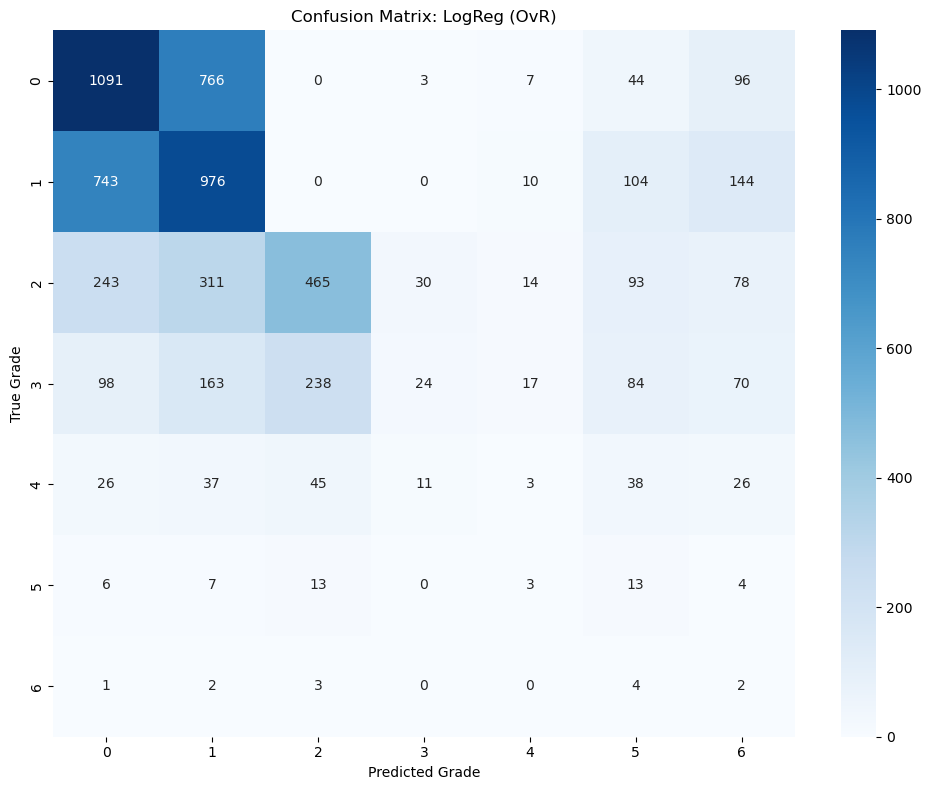

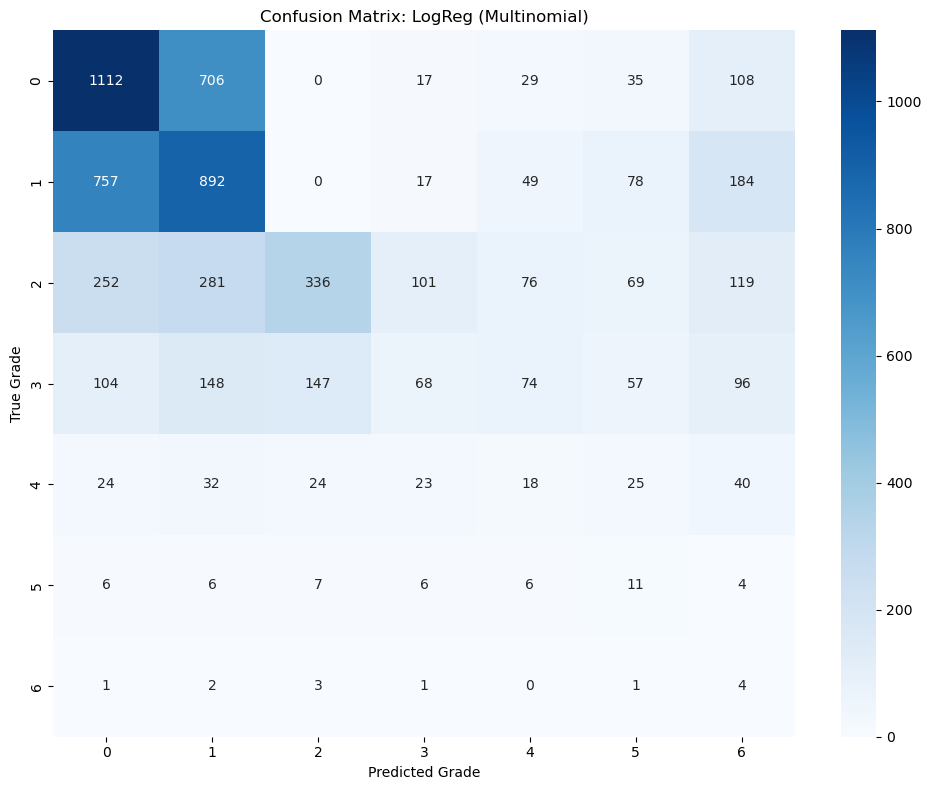

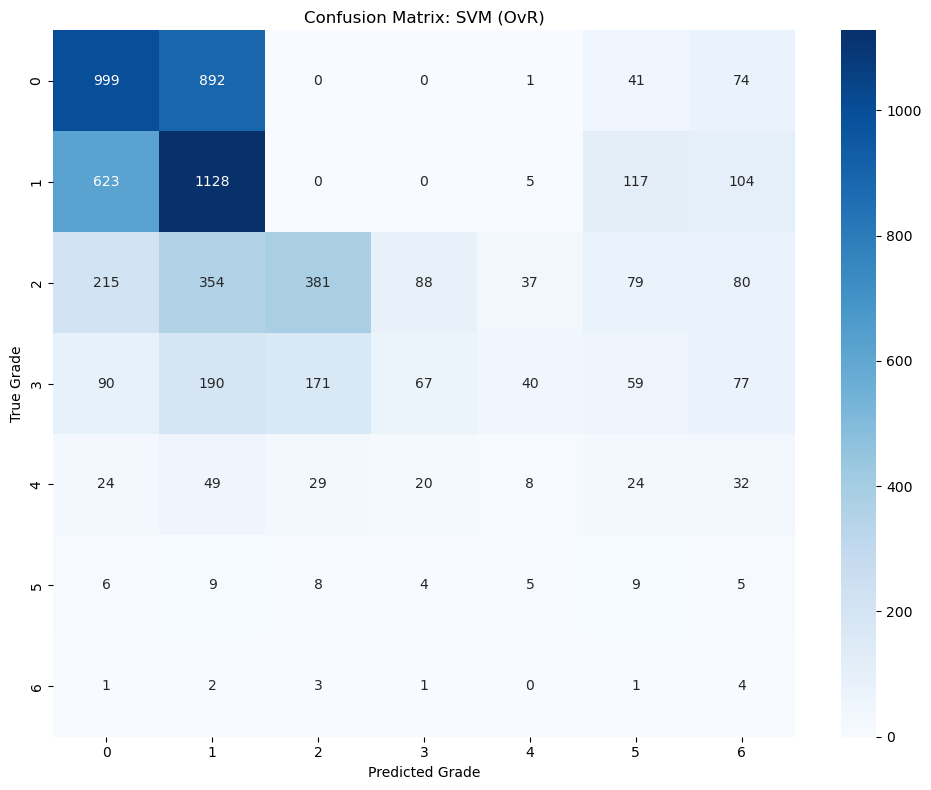

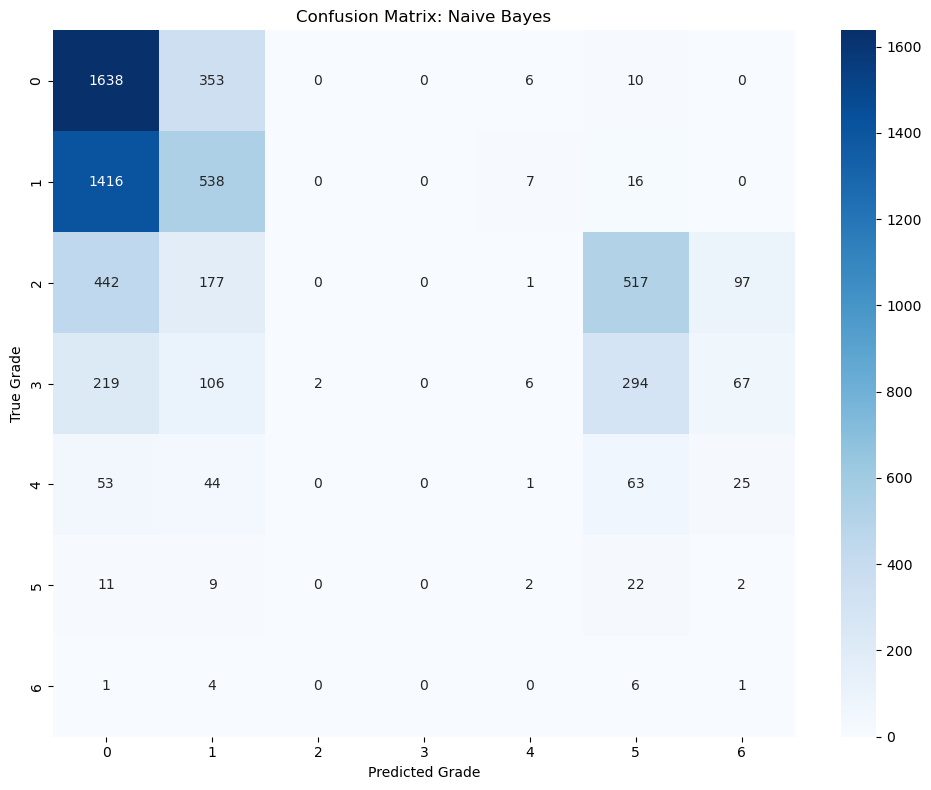

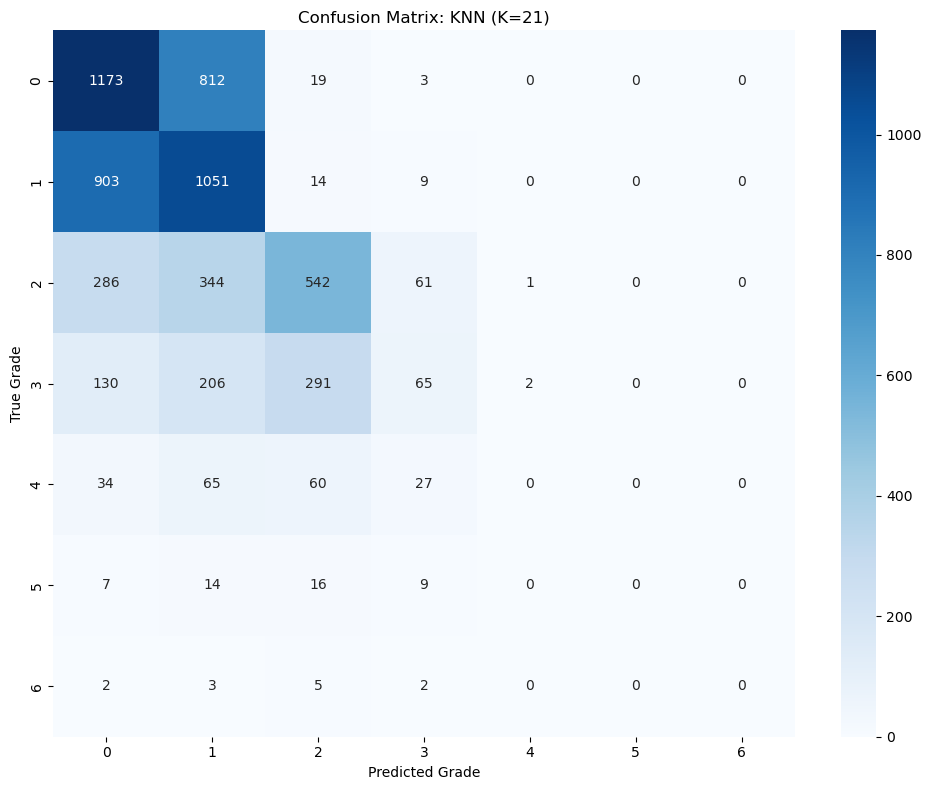

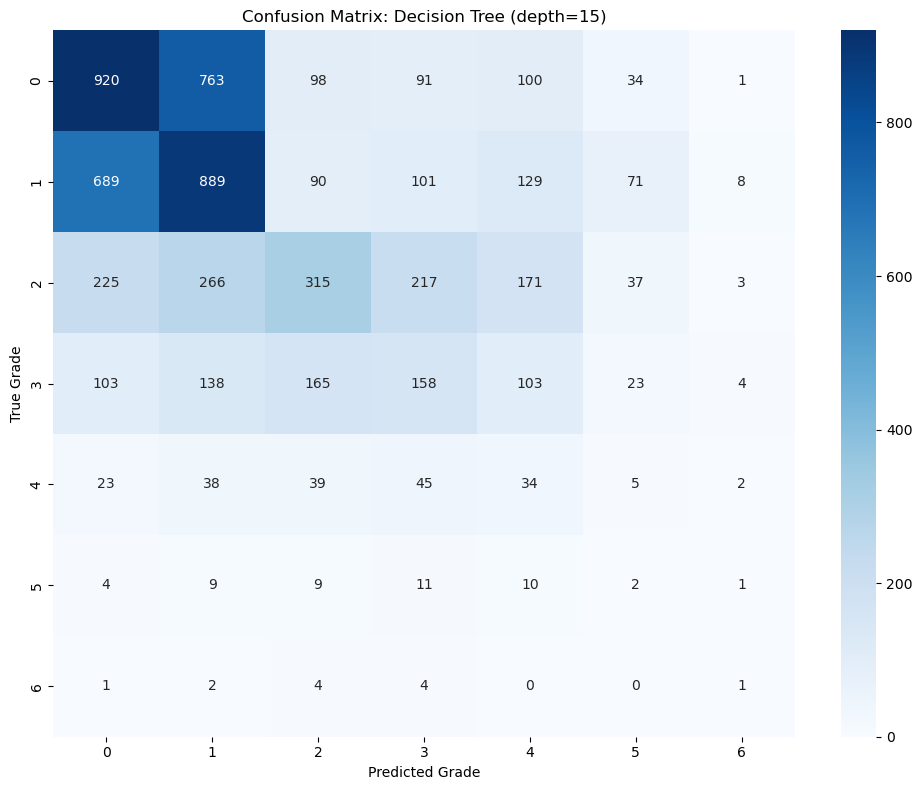

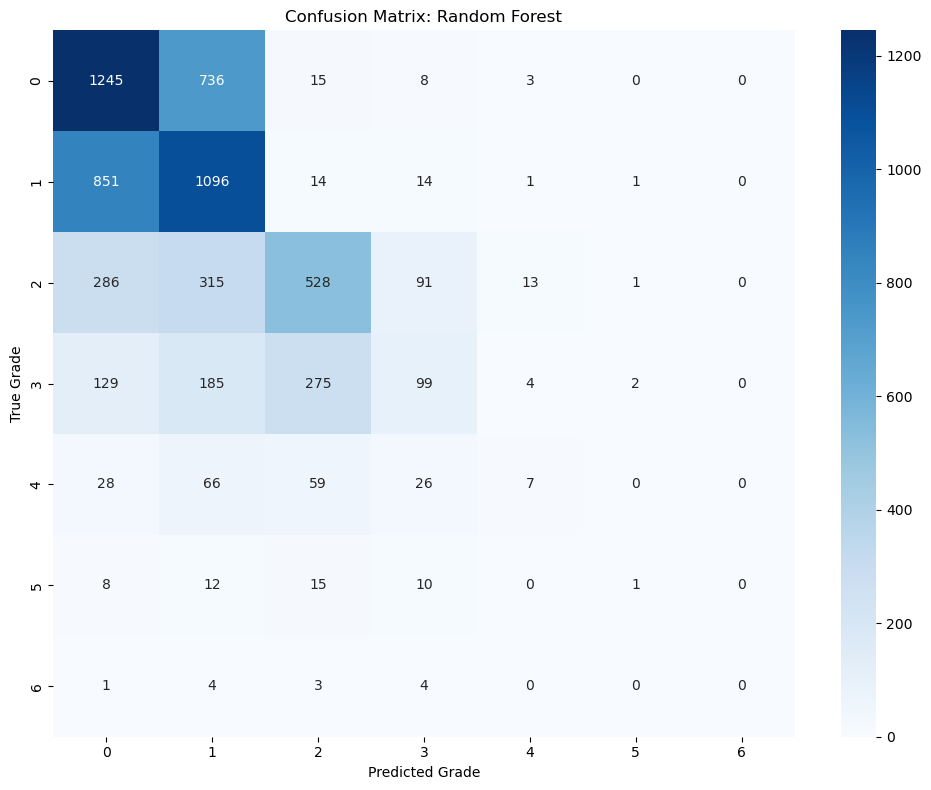

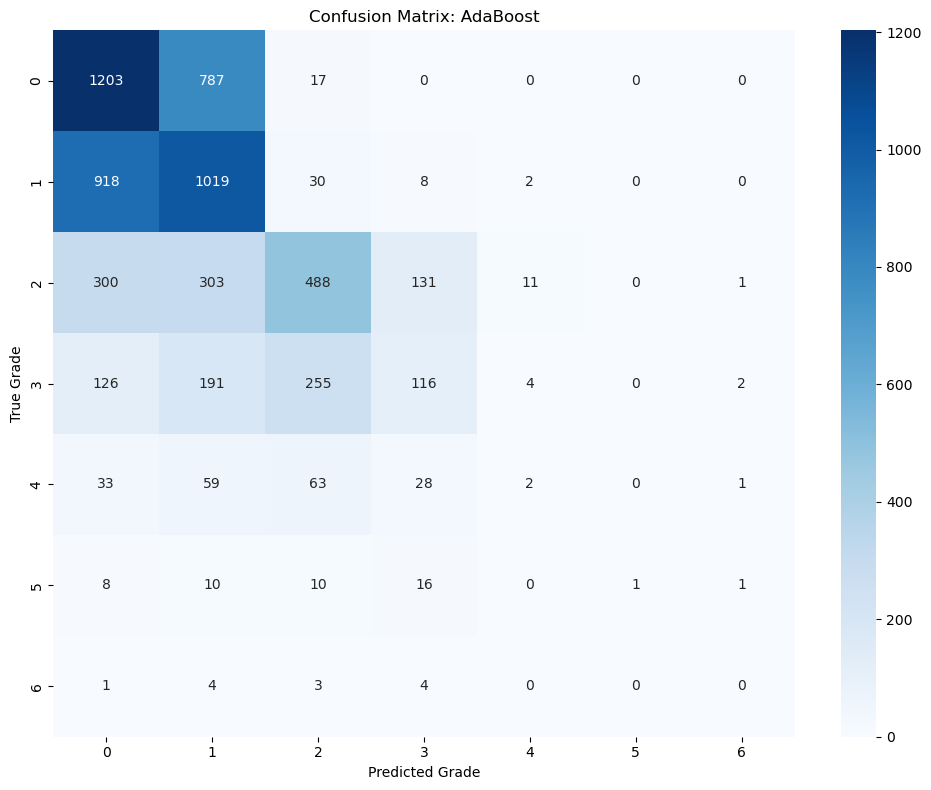

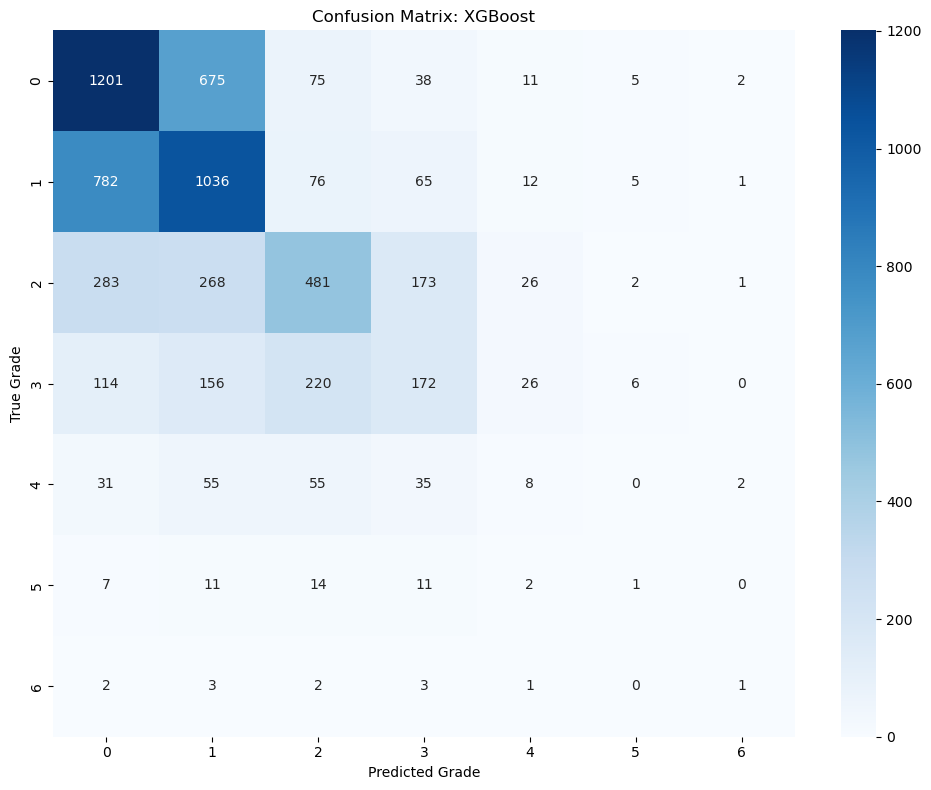

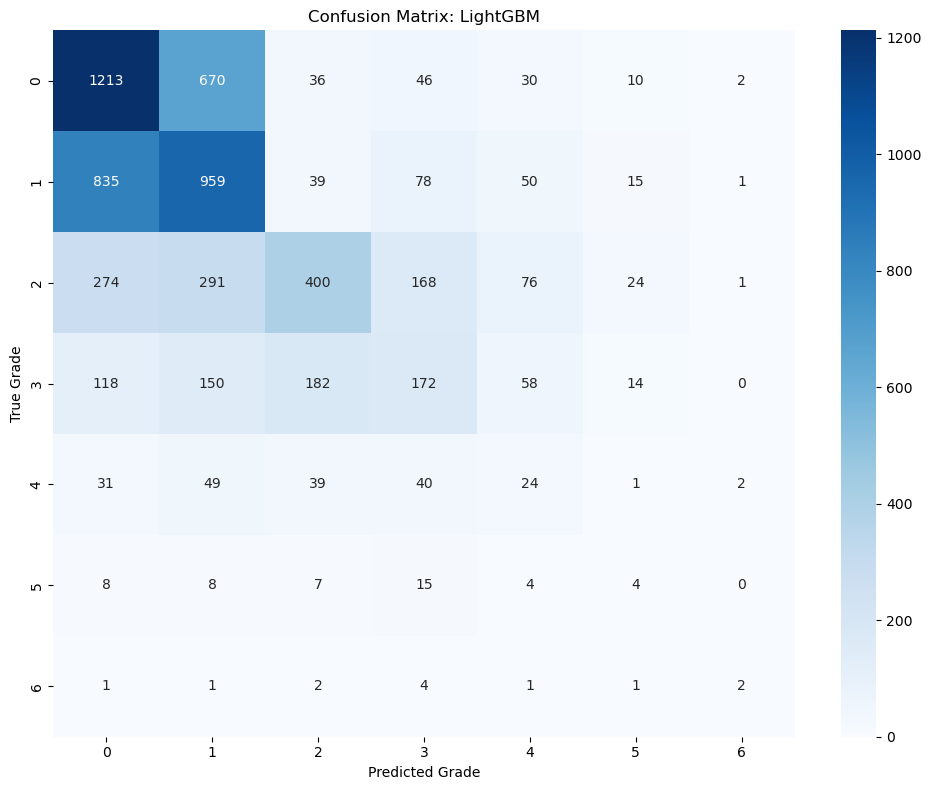

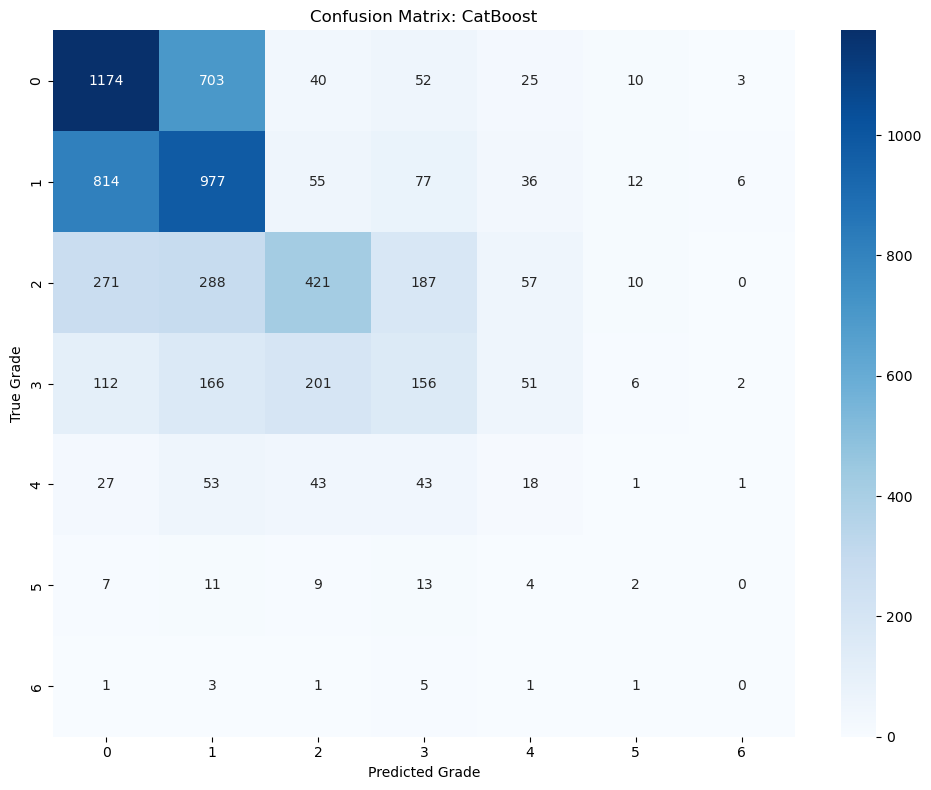


 Multiclass modeling complete!


In [49]:
# Confusion Matrix

def plot_confusion_matrix_heatmap(cm, model_name):
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=unique_classes,
        yticklabels=unique_classes
    )
    plt.title(f'Confusion Matrix: {model_name}')
    plt.ylabel('True Grade')
    plt.xlabel('Predicted Grade')
    plt.tight_layout()
    plt.show()

print("\n" + "="*60)
print(" CONFUSION MATRICES")
print("="*60)

for result in results:
    if not pd.isna(result.get('Accuracy', np.nan)):
        plot_confusion_matrix_heatmap(result['ConfusionMatrix'], result['Model'])

print("\n Multiclass modeling complete!")

### lets take a look at recall per class
 
Overall accuracy/Kappa hide the real failure mode: **models look good on A/B/C but completely collapse on E/F/G**:

- Many “high-accuracy” models basically **never** predict F or G → every bad loan gets mis-graded as safe. (this is a data limitation not model performance)  
- Models with lower overall metrics often have **much better recall on the tail**, which is what prevents catastrophic underpricing of risk.

PER-CLASS RECALL ANALYSIS
                   Model  Recall_A  Recall_B  Recall_C  Recall_D  Recall_E  Recall_F  Recall_G
            LogReg (OvR)     0.544     0.494     0.377     0.035     0.016     0.283     0.167
    LogReg (Multinomial)     0.554     0.451     0.272     0.098     0.097     0.239     0.333
               SVM (OvR)     0.498     0.571     0.309     0.097     0.043     0.196     0.333
             Naive Bayes     0.816     0.272     0.000     0.000     0.005     0.478     0.083
              KNN (K=21)     0.584     0.532     0.439     0.094     0.000     0.000     0.000
Decision Tree (depth=15)     0.458     0.450     0.255     0.228     0.183     0.043     0.083
           Random Forest     0.620     0.554     0.428     0.143     0.038     0.022     0.000
                AdaBoost     0.599     0.515     0.395     0.167     0.011     0.022     0.000
                 XGBoost     0.598     0.524     0.390     0.248     0.043     0.022     0.083
                LightGBM

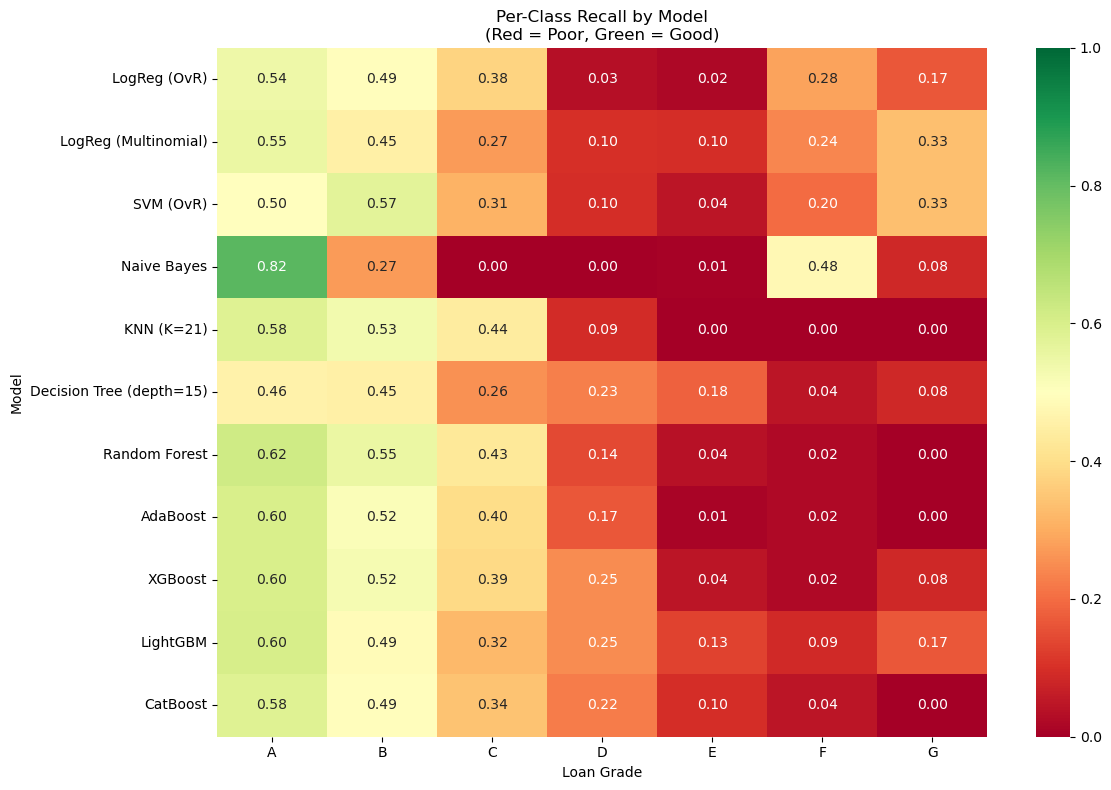

In [53]:
# Per-class recall analysis

print("PER-CLASS RECALL ANALYSIS")
print("="*60)

class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
recall_data = []

for result in results:
    if 'Recall_PerClass' in result and not pd.isna(result.get('Accuracy')):
        row = {'Model': result['Model']}
        for i, cls in enumerate(class_names):
            row[f'Recall_{cls}'] = result['Recall_PerClass'][i]
        recall_data.append(row)

recall_df = pd.DataFrame(recall_data)
print(recall_df.round(3).to_string(index=False))

# Heatmap of per-class recall
plt.figure(figsize=(12, 8))
recall_matrix = recall_df.set_index('Model')[[f'Recall_{c}' for c in class_names]]
recall_matrix.columns = class_names
sns.heatmap(recall_matrix, annot=True, fmt='.2f', cmap='RdYlGn', vmin=0, vmax=1)
plt.title('Per-Class Recall by Model\n(Red = Poor, Green = Good)')
plt.xlabel('Loan Grade')
plt.ylabel('Model')
plt.tight_layout()
plt.show()

# Fundamental Limitation of the Data & Task:

The dataset itself puts a hard ceiling on model performance:

- **Severe class imbalance:** Grades E/F/G make up *less than 4%* of all loans, while A/B dominate with 65%. Models simply don’t get enough examples to learn the subprime tail properly.
- **Weak feature set:** We only have 12 borrower variables. Real lenders use hundreds (bureau data, payment history, verified income, utilization patterns,...). With such thin signal, my model can’t separate fine-grained risk levels.
- **Ordinal complexity:** Predicting **7 ordered grades** is much harder than a binary default model, especially when the rarest grades have almost no training samples.


### Kappa Is the Most Appropriate Metric for Loan Grade Prediction

1. **Ordered Classes**  
   Loan grades (A to G) are *ordinal*. A is strictly better than B, B better than C, and so on.  
   Regular accuracy treats predicting **A to G** the same as **A to B**, which makes no sense.  
   Kappa, on the other hand, penalizes big mistakes more heavily and rewards models that respect the natural ordering of the grades.

2. **Severe Class Imbalance**  
   The grade distribution is skewed:  
   - A ≈ 35%  
   - B ≈ 30%  
   - C ≈ 20%  
   - D+E+F+G < 15%  
   
   Accuracy (and even F1-Micro) get dominated by A/B because a model can do well just by predicting the majority classes.  
   Kappa adjusts for chance agreement, so it won’t get tricked by a model that always predicts A/B.

3. **Business Meaning**  
   In credit risk, overestimating credit quality by multiple notches (for example predicting **B** when it’s actually **E**) is financially disastrous.  
   Being off by a single grade is tolerable; being off by three grades is not.  
   Kappa captures this idea by measuring agreement beyond what would happen by chance, aligning perfectly with the real-world cost of misgrading.



## Extending KNN and Decision Trees to Multi-Label Classification

**KNN:**  
KNN is naturally flexible, so extending it to multi-label classification is straightforward.  
- For a given player, you find the *k* nearest neighbors as usual.  
- But instead of predicting a single class, you look at the labels of all neighbors across all 4 classes.  
- For each label, you can either take a **majority vote**, or average the neighbors’ label values and threshold them (for example predict label = 1 if more than half the neighbors have it).
  
Basically, KNN predicts each label independently using the same neighbor set.

**Decision Trees:**  
For decision trees, there are two main ways to handle multi-label output:  
1. **One-vs-Rest Trees** – Train a separate decision tree for each label. So you'd end up with 4 trees—one predicting “has played for national team,” one predicting “heart problems,” etc.  
2. **Multi-Output Decision Trees** – Some implementations (like scikit-learn) can train a *single* tree that predicts multiple labels at once. During training, splits are chosen to reduce impurity across *all* labels jointly.
3. **Label Powerset:** Treat each unique combination of labels as a single class (can blow up in size).
4. **Classifier Chains:** Arrange labels in a chain, using predictions of previous labels as features for next ones.


## Best Accuracy Metric for This Football Multi-Label Problem

**Macro-F1 (F1-macro)**

Why:

- Multi-label with class imbalance: Some labels (lets say “history of heart problems”) are rare but critical, while others (like “played for national team”) may be more common. Macro-F1 calculates F1 per class and then averages them, giving equal weight to each class. This ensures that performance on rare classes isn’t drowned out by performance on frequent classes.

Practical relevance: In this football context, each label serves a different purpose (health risk, experience, leadership). You likely care about precision and recall for each class independently. Macro-F1 reflects how well the model handles each distinct aspect.

**Comparison to alternatives:**

- *Micro-F1*: Favors frequent classes; not ideal if rare classes are important.

- *Hamming Loss*: Good for overall label accuracy, but doesn’t distinguish precision/recall per class.

- *Exact Match Ratio*: Too strict; partial correctness matters here.

Thus, Macro-F1 best balances the need to evaluate all four classes fairly, especially when some are rare but critical.


# Part 4

## 1. Choose the Best Classification Metric for Your Dataset and Justify

In the context of predicting **loan status** in a **credit risk** dataset, **AUC (Area Under the Curve)** is the most appropriate classification metric. because:

- **AUC** measures the model's ability to distinguish between **defaults** (loan status = 1) and **non-defaults** (loan status = 0) across all classification thresholds. Given that **credit risk prediction** is about identifying high-risk customers (defaults), we need a metric that accounts for the entire range of possible thresholds and not just a fixed decision boundary.
- **Precision** and **Recall** are also important, but in **credit risk**, **Recall** (sensitivity) is often more critical than **Precision**, since we want to catch as many **defaults** as possible. If the model misses a lot of defaults (false negatives), it could lead to risky lending decisions. which is bad for business! That's why **AUC** is particularly valuable because it summarizes performance across both precision and recall while giving us the flexibility to set the threshold that best balances these trade-offs.
- In our results, **Kernel SVM** (with an AUC of 0.8269) performs the best across most metrics, showing its better ability to distinguish between default and non-default instances in the dataset.

---

## 2. Explain 3 Techniques to Regularize the Training Process for Decision Trees

When training a decision tree for **credit risk prediction**, regularization is essential to prevent overfitting to the training data. Here are three key techniques:

1. **Limiting Maximum Depth**  
   By setting a maximum depth (e.g., `depth=10` in our Decision Tree), we restrict the tree from growing too deep and capturing irrelevant details that don't generalize well. This is particularly important in **credit risk**, as overly deep trees might overfit to noisy or non-representative training data and fail to make accurate predictions for new applicants.

2. **Minimum Samples per Leaf**  
   This parameter ensures that each leaf node contains a minimum number of samples. In a credit risk context, if a leaf node only contains a handful of observations, the model might be overly sensitive to noise or rare cases. By setting a higher value for `min_samples_leaf`, we ensure that each decision rule in the tree is based on a sufficiently large sample, which makes the model more robust.

3. **Pruning**  
   After the tree has been built, pruning removes branches that have little predictive value, reducing complexity. In **credit risk**, pruning helps simplify the model, making it easier to interpret and less likely to overfit to training data, which is especially important when explaining decisions to non-technical stakeholders (like loan officers or regulators).

---

## 3. Compare Linear SVM vs Kernel SVM

### **Linear SVM**
- **Performance:** Linear SVM performs well when the dataset has a **linear decision boundary**. However, in **credit risk prediction**, the relationship between features (like income, credit score, and loan amount) and the target (loan status) is often not a perfect linear relationship. Our results show **Linear SVM** has an accuracy of **0.7568** and performs decently, but its precision and recall are slightly lower compared to **Kernel SVM**.
- **Speed:** Linear SVM is faster to train than Kernel SVM, especially for large datasets, since it directly computes the decision boundary using a linear kernel. In practice, this means that if the data is relatively simple and linear, Linear SVM can be a more efficient choice.
- **Interpretability:** The decision boundary of Linear SVM is easier to visualize and understand, which can be helpful when explaining model decisions to stakeholders (for example a loan officer trying to understand why a customer was denied a loan).

### **Kernel SVM**
- **Performance:** Kernel SVM works well when the data is **non-linearly separable**, which is typical in **credit risk** datasets. By using a kernel function (like RBF), Kernel SVM maps the data into a higher-dimensional space where it can find a linear decision boundary. In our results, **Kernel SVM** achieves the highest **accuracy (0.7903)** and shows a better balance between **Precision** and **Recall**, making it the most effective model for this dataset.
- **Flexibility:** Kernel SVM is much more flexible than Linear SVM because it can handle complex, non-linear relationships between features and the target. This is useful when predicting **loan status**, as factors like credit score and income interact in a non-linear way.
- **Interpretability:** The decision boundary is more complex, and it’s harder to interpret compared to Linear SVM. This is a drawback if you need to explain the model's decisions to business users or regulators, especially in the **credit risk** domain where interpretability is key.

---
### so in a nutshell:  
- If the data is linearly separable or almost linearly separable, **Linear SVM** might be faster and simpler to implement.
- If the data has complex, non-linear relationships, **Kernel SVM** is likely to perform better, providing the best balance of **Precision**, **Recall**, and **AUC**. In this dataset, Kernel SVM outperforms Linear SVM across multiple metrics, making it the preferred choice for predicting **loan status**.


# Part 4

## 0. Explain bias–variance trade-off in regression models

The bias-variance trade-off is a fundamental concept in machine learning that describes the tension between two sources of error in predictive models: bias and variance.

- **Bias** refers to the error introduced by approximating a real-world problem (which may be complex) with a simplified model. High bias means the model makes strong assumptions about the data, leading to underfitting. For example, a linear regression model applied to nonlinear data will have high bias because it can't capture the true underlying patterns.

- **Variance** refers to the error introduced by the model's sensitivity to small fluctuations in the training data. High variance means the model learns noise instead of the signal, leading to overfitting. For instance, a high-degree polynomial regression might fit the training data perfectly but perform poorly on new data.

The trade-off implies that as you decrease bias (for example by using more complex models), variance increases, and vice versa. The goal is to find a sweet spot where the total error (bias + variance + irreducible error) is minimized. In regression, this is often visualized with mean squared error (MSE) decomposition: MSE = Bias² + Variance + Irreducible Error.

Techniques like regularization, cross-validation, and ensemble methods help balance this trade-off.


## 1. When does Kernel Regression outperform Linear Regression

Kernel regression (or kernel ridge regression/nonparametric regression) outperforms linear regression in scenarios where the relationship between features and the target is nonlinear or complex, and the data doesn't conform to linear assumptions.

- **Nonlinear relationships**: Linear regression assumes a linear mapping, but kernels (RBF) map data to higher dimensions where nonlinear patterns become linear, capturing curves, interactions, or clusters better.

- **High-dimensional or sparse data**: Kernels handle the "curse of dimensionality" by focusing on similarities between points rather than explicit feature spaces.

- **Small to medium datasets**: Kernel methods excel when n (samples) is not too large, as computation scales with n², but they generalize well without needing many parameters.

- **When flexibility is needed without overfitting control issues**: With proper bandwidth/regularization, kernels smooth predictions adaptively.

However, linear regression is preferable for large-scale linear data due to simplicity, interpretability, and efficiency. Kernel regression is better in tasks like time-series forecasting with seasonal patterns or image processing where local similarities matter.


## 2. Compare L1 vs L2 regularization

L1 (Lasso) and L2 (Ridge) regularization are techniques to prevent overfitting in regression models by adding a penalty to the loss function.

- **L1 Regularization (Lasso)**: Adds the absolute value of coefficients to the loss. It encourages sparsity by driving some coefficients to exactly zero.

- **L2 Regularization (Ridge)**: Adds the squared value of coefficients to the loss. It shrinks coefficients towards zero but rarely sets them exactly to zero, distributing the penalty across all features.

* When does LASSO perform better? Lasso excels in high-dimensional data with many irrelevant features, as it performs implicit feature selection, leading to simpler, more interpretable models. It's ideal for sparse datasets like genomics or text data.

* When does Ridge perform better? Ridge is better when all features are relevant or when there's multicollinearity (correlated features), as it stabilizes estimates by shrinking correlated coefficients together without eliminating them. It performs well in scenarios with small sample sizes relative to features.

* Why does LASSO produce sparsity? The L1 penalty creates a diamond-shaped constraint in the coefficient space. The optimal solution often hits the axes (where some coefficients are zero) due to the geometry of the L1 norm, unlike the circular L2 norm which touches the constraint smoothly.

Elastic Net combines both for balanced performance.


## 3. Explain why MAPE is unreliable in some datasets

Mean Absolute Percentage Error (MAPE) measures regression accuracy as the average absolute percent error: (1/n) * Σ |(actual - predicted)/actual| * 100%.

MAPE is unreliable in datasets with:

- **Zeros or near-zeros in actual values**: Division by zero causes undefined values, or small denominators amplify errors disproportionately (like if actual is 0.01, a small absolute error like 0.01 becomes 100% error).

- **Negative values**: Percentage errors don't make sense with negatives, leading to asymmetric interpretations (overprediction vs. underprediction).

- **Scale variability**: It's scale-dependent and biased towards low-magnitude values; errors in small actuals dominate, making it unsuitable for heterogeneous data like financial time series with varying scales.

- **Outliers**: Extreme values skew percentages, overemphasizing relative errors in low-value regions.

## 4. Discuss the effect of outliers on regression models

Outliers are data points that deviate significantly from the norm and can severely impact regression models:

- **Linear Regression**: Highly sensitive due to least squares minimization. Outliers pull the regression line towards them, increasing bias and variance, leading to poor generalization. They inflate MSE and can distort coefficient estimates.

- **Robust Regression (Huber, RANSAC,...)**: Less affected as they downweight outliers or iteratively exclude them, preserving the fit for the majority of data.

- **Tree-based Models**: More robust as splits isolate outliers in separate leaves, but deep trees might overfit to them.

- **Effect on Metrics**: Outliers skew residuals, making metrics like R² unreliable. They can also violate assumptions like homoscedasticity.

To mitigate this we can use robust scalers, transformations (like log), outlier detection (Z-score, IQR,...), or ensemble methods.


## 5. Explain the effect of class imbalance on binary metrics. Why is accuracy misleading in imbalanced datasets

Class imbalance occurs when one class dominates, affecting binary classification metrics:

- **Impact on Metrics**: Metrics like precision, recall, and F1 are skewed. A model predicting all as majority class gets high accuracy but fails on minority class.

- **Why Accuracy is Misleading**: Accuracy = (TP + TN)/(TP + TN + FP + FN). In imbalance, high TN inflates it (example: 95% accuracy by always predicting negative, ignoring positives). It doesn't reflect performance on the rare class, crucial in applications like fraud detection or disease diagnosis.

## 6. Explain how the decision boundaries of your models differ fundamentally

The fundamental difference lies in how each model partitions the feature space to separate defaulters from non-defaulters. Linear models (Logistic Regression, Linear SVM) draw a single flat hyperplane, making them fast and interpretable but blind to interactions—treating a high-income/high-DTI borrower the same as a low-income/high-DTI one. Kernel SVM creates smooth curved boundaries by mapping data to higher dimensions, while KNN forms irregular local patches based on nearest neighbors. Decision Trees use axis-aligned boxes that naturally capture interaction effects like our engineered `high_risk_flag`, and Random Forest improves this by averaging many such boxes to reduce overfitting.

Random Forest's victory (AUC=0.9086) stems from this geometric match: credit risk is inherently rule-based ("deny if DTI>40% AND past default"), which trees express perfectly through layered if-then splits, while the ensemble smooths out spurious rules learned from noise. Kernel methods underperformed because credit risk relationships are piecewise-linear, not smoothly curved, and Naive Bayes failed due to its false independence assumption between correlated features like income and loan amount.

The lesson is clear—**we should choose geometry that mirrors our problem's structure**: rules for credit risk, curves for natural phenomena, planes for simple linear relationships.

## 7. Explain effect of K in KNN

In K-Nearest Neighbors (KNN), K is the number of nearest neighbors considered for prediction:

- **Small K**: Low bias, high variance. Decision boundaries are complex and noisy, capturing local patterns but overfitting to outliers or noise. Sensitive to data fluctuations.

- **Large K**: High bias, low variance. Boundaries smooth out, averaging more points, reducing overfitting but potentially underfitting by ignoring local structure. Approaches the global mode/mean.

- **Optimal K**: Balances bias-variance via cross-validation (e.g., elbow method on error rate). Depends on dataset size, noise, and dimensionality.

K also affects computation (larger K slower) and ties (odd K for binary classification).


## 8. Overfitting in Decision Trees:

Decision trees are prone to overfitting due to their flexibility.

* Why do decision trees overfit easily? They recursively split until pure leaves, capturing noise as signal. Without constraints, they grow deep, memorizing training data (low bias, high variance), leading to poor generalization.

* Why is max depth not enough? Max depth limits tree height but doesn't address other issues like imbalanced splits or low-information gains. Trees can still overfit within depth limits if splits are on noisy features.

* How pruning works? Pruning removes branches post-growth (cost-complexity pruning) or during (pre-pruning via min_samples_leaf, min_impurity_decrease). It reduces complexity by merging leaves or cutting subtrees if they don't improve validation error, balancing fit and generalization.

## 9. Explain why Tree-based models are good feature selectors

Tree-based models (Decision Trees, Random Forests, Gradient Boosting) excel at feature selection due to inherent mechanisms:

- **Feature Importance Scores**: They compute importance via metrics like Gini impurity reduction or information gain per split. Features reducing impurity most across trees are deemed important.

- **Handling Irrelevance**: Trees ignore useless features by not selecting them for splits, naturally performing selection without preprocessing.

- **Nonlinear and Interaction Capture**: They rank features accounting for interactions and nonlinearities, unlike linear models.

- **Robustness**: Ensemble versions (RF) average importances, reducing variance and noise bias.

## 10. Micro vs Macro vs Weighted F1

F1 score is the harmonic mean of precision and recall, extended for multiclass.

- **Micro F1**: Global average—aggregates TP, FP, FN across classes, then computes F1. Treats all instances equally.

- **Macro F1**: Averages F1 per class (unweighted). Equal weight to each class.

- **Weighted F1**: Averages F1 per class, weighted by class support (instance count).

* When is Macro F1 a better reflection? In imbalanced datasets where minority classes matter equally (e.g., rare disease detection); it doesn't favor large classes.

* When is Weighted F1 misleading? When large classes dominate, masking poor minority performance, similar to accuracy in imbalance.

* Why does Micro F1 favor large classes? It pools counts globally, so large classes' metrics overshadow small ones, equivalent to weighted by total instances.

## 11. Multi-label vs Multiclass

Multi-label and multiclass classification differ in handling multiple categories.

* Explain the fundamental difference: Multiclass assigns one label from mutually exclusive classes (cat/dog/bird). Multi-label assigns multiple non-exclusive labels (a movie as comedy AND action).

  * Output space: Multiclass: Single probability distribution (softmax, sum to 1). Multi-label: Independent probabilities per label (sigmoid, 0-1 each).

  * Loss functions: Multiclass: Categorical cross-entropy. Multi-label: Binary cross-entropy per label (summed).

  * Thresholding: Multiclass: Argmax. Multi-label: Threshold (e.g., 0.5) per label for binary decisions.

  * Metrics: Multiclass: Accuracy, F1 (macro/micro). Multi-label: Hamming loss, subset accuracy, label-wise F1, mAP.

    * Why KNN and Decision Trees can be extended for multi-label classification? KNN: Average neighbors' labels or use multi-label distance. Trees: Multi-output trees split on multi-label criteria, or one-vs-rest ensembles.


## 12. Explain precision–recall trade-off

The precision-recall trade-off describes the inverse relationship in classification thresholds:

- **Precision**: Proportion of positive predictions that are true (TP/(TP+FP)). High precision minimizes false positives.

- **Recall**: Proportion of actual positives correctly predicted (TP/(TP+FN)). High recall minimizes false negatives.

Increasing the threshold raises precision (fewer positives, more accurate) but lowers recall (misses some positives). Decreasing it boosts recall but drops precision.

Trade-off is managed via operating point selection (like F1 max). Crucial in imbalance: Focus recall for rare events (like cancer detection), precision for costly false positives (spam emails...).

## 13. Explain ROC vs PR curve

ROC (Receiver Operating Characteristic) and PR (Precision-Recall) curves evaluate binary classifiers across thresholds.

- **ROC Curve**: Plots True Positive Rate (Recall) vs. False Positive Rate. AUC-ROC measures discrimination; robust to imbalance as FPR normalizes negatives.

- **PR Curve**: Plots Precision vs. Recall. AUPRC focuses on positive class performance; better for imbalanced datasets where positives are rare, as it doesn't include TN (which inflate ROC in imbalance).

Differences: ROC is optimistic in imbalance (high AUC even if poor on minorities); PR drops sharply.we use ROC for balanced data, PR for skewed. Both summarize trade-offs, but PR is preferred when positives matter most (in fraud detection for example).

## 14. If you had unlimited time and resources, how would you improve your models think:

* Better preprocessing: Advanced handling like automated outlier detection (isolation forests), feature scaling/normalization per model, handling missing data with imputation models (MICE), and domain-specific transforms (NLP embeddings).

* Better features: Engineer via domain knowledge or use AutoML for generation (TSFresh for time-series), incorporate external data (APIs), or deep learning for automatic extraction (CNNs for images).

* Better models: Ensemble stacking/meta-learning, advanced architectures (transformers, graph NNs), hyperparameter optimization with Bayesian methods, or custom models via neural architecture search.

* Better metrics: Custom/domain-specific (cost-sensitive for business), robust to issues (Cohen's Kappa for imbalance), multi-metric evaluation (Pareto fronts), and uncertainty quantification (conformal prediction).
